# Реализация сильного бейзлайна

In [ ]:
import pandas as pd
data = pd.read_csv('/kaggle/input/dls-project-ds/train_maps_big.csv')
# датасет для первого варианта
# отдельные фичи: запрос, адрес, название, нормализованное название, цены, отзывы и склейка через теги всех этих признаков
# None заменен на [Empty]

In [3]:
data

,Text,address,name,normalized_main_rubric_name_ru,prices_summarized,reviews_summarized,full,relevance
0,налоговая 5007,"Московская область, Королёв, улица Богомолова, 4",Налоговая служба; Межрайонная ИФНС № 2; ИФНС №...,Налоговая инспекция,[Empty],Организация занимается обслуживанием налогопла...,[Request]\n налоговая 5007\n [Address]\n Мо...,0.0
1,шугаринг Красноярск,"Красноярск, микрорайон Взлётка, улица Весны, 3",Студия красоты Дарлинг; Darling; Дарлинг,Салон красоты,Студия красоты «Дарлинг» предоставляет услуги ...,Студия красоты «Дарлинг» предоставляет бьюти-у...,[Request]\n шугаринг Красноярск\n [Address]\...,1.0
2,новогодняя ночь 2018 в ресторане,"Москва, Кутузовский проспект, 36А",Atlantica seafood; Коллекция; Коллекция Food &...,Ресторан,Ресторан Atlantica предлагает разнообразные бл...,Организация занимается ресторанным бизнесом и ...,[Request]\n новогодняя ночь 2018 в ресторане\...,1.0
3,балетная школа в санкт петербурге 12лет с прож...,"Санкт-Петербург, Невский проспект, 35В",Русская национальная балетная школа Илзе Лиепа...,Школа танцев,[Empty],Организация занимается обучением балету и хоре...,[Request]\n балетная школа в санкт петербурге...,0.0
4,солкосерил гель цена,"Москва, Симферопольский бульвар, 29, корп. 1",Столички; Stolichki; Apteki Stolichki,Аптека,Аптека «Столички» предлагает широкий спектр ле...,Организация занимается продажей лекарств и мед...,[Request]\n солкосерил гель цена\n [Address]...,1.0
...,...,...,...,...,...,...,...,...
29886,нотариус запись,"Москва, 15-я Парковая улица, 45",Нотариус О. Н. Савина; Notarius O. N. Savina; ...,Нотариусы,[Empty],Организация предоставляет нотариальные услуги ...,[Request]\n нотариус запись\n [Address]\n М...,1.0
29887,стационар для кота москва,"Москва, улица Госпитальный Вал, 3, корп. 5",ТриоВет; Triovet; Триовет; Veterinaria Triovet,Ветеринарная клиника,"Ветеринарная клиника, аптека и лаборатория «Тр...","Организация занимается ветеринарными услугами,...",[Request]\n стационар для кота москва\n [Add...,0.0
29888,агзс пропан,"Самара, улица 22-го Партсъезда, 49, корп. 1",Роза Мира; АЗС № 2; Роза мира,АЗС,[Empty],Организация занимается заправкой транспортных ...,[Request]\n агзс пропан\n [Address]\n Самар...,0.0
29889,где вибрить ваз 2112,"Нижний Новгород, Московское шоссе, 34","Нижегородец, Lada; Nizhegorodec, Lada; Нижегор...",Автосалон,Автосалон «Нижегородец» предлагает новые автом...,Автосалон «Нижегородец» занимается продажей и ...,[Request]\n где вибрить ваз 2112\n [Address]...,0.0


In [13]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd

class MapsDataset(Dataset):
    def __init__(self, request, address, name, norm_name, prices, reviews, full, target):
        self.request = request
        self.address = address
        self.name = name
        self.norm_name = norm_name
        self.prices = prices
        self.reviews = reviews
        self.full = full
        self.target = torch.tensor(target, dtype=torch.float32)
    def __len__(self):
        return len(self.full)
    def __getitem__(self, idx):
        return {
            'request': self.request[idx],
            'address': self.address[idx],
            'name': self.name[idx],
            'norm_name': self.norm_name[idx],
            'prices': self.prices[idx],
            'reviews': self.reviews[idx],
            'full': self.full[idx],
            'target': self.target[idx]
        }
train_set = data.sample(frac=0.9)
val_set = data.drop(train_set.index)
train_ds = MapsDataset(
    request=train_set['Text'].tolist(),
    address=train_set['address'].tolist(),
    name=train_set['name'].tolist(),
    norm_name=train_set['normalized_main_rubric_name_ru'].tolist(),
    prices=train_set['prices_summarized'].tolist(),
    reviews=train_set['reviews_summarized'].tolist(),
    full=train_set['full'].tolist(),
    target=train_set['relevance'].tolist()
)
val_ds = MapsDataset(
    request=val_set['Text'].tolist(),
    address=val_set['address'].tolist(),
    name=val_set['name'].tolist(),
    norm_name=val_set['normalized_main_rubric_name_ru'].tolist(),
    prices=val_set['prices_summarized'].tolist(),
    reviews=val_set['reviews_summarized'].tolist(),
    full=val_set['full'].tolist(),
    target=val_set['relevance'].tolist()
)

def custom_collate(batch): # из-за некоторых возникающих ошибок пришлось написать кастомную функцию объединения в батч
    return {
        'request': [item['request'] for item in batch],
        'address': [item['address'] for item in batch],
        'name': [item['name'] for item in batch],
        'norm_name': [item['norm_name'] for item in batch],
        'prices': [item['prices'] for item in batch],
        'reviews': [item['reviews'] for item in batch],
        'full': [item['full'] for item in batch],
        'target': torch.tensor([item['target'] for item in batch], dtype=torch.float)
    }

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, collate_fn=custom_collate)
val_loader = DataLoader(val_ds, batch_size=16, collate_fn=custom_collate)

In [1]:
import torch
from torch import nn
from transformers import AutoTokenizer, AutoModel

class Baseline(nn.Module):
    def __init__(self, base_transformer_model, out_len):
        super().__init__()
        # отдельно будем обучать эмбеддинги для каждого поля
        self.tokenizer = AutoTokenizer.from_pretrained(base_transformer_model, output_hidden_states=True)
        self.request_emb = AutoModel.from_pretrained(base_transformer_model, output_hidden_states=True)
        self.address_emb = AutoModel.from_pretrained(base_transformer_model, output_hidden_states=True)
        self.name_emb = AutoModel.from_pretrained(base_transformer_model, output_hidden_states=True)
        self.norm_name_emb = AutoModel.from_pretrained(base_transformer_model, output_hidden_states=True)
        self.prices_emb = AutoModel.from_pretrained(base_transformer_model, output_hidden_states=True)
        self.reviews_emb = AutoModel.from_pretrained(base_transformer_model, output_hidden_states=True)
        self.full_emb = AutoModel.from_pretrained(base_transformer_model, output_hidden_states=True)
        
        self.linear1_rq = nn.Linear(out_len,128)
        self.linear1_a = nn.Linear(out_len,128)
        self.linear1_n = nn.Linear(out_len,128)
        self.linear1_nn = nn.Linear(out_len,128)
        self.linear1_p = nn.Linear(out_len,128)
        self.linear1_rv = nn.Linear(out_len,128)
        self.linear1_f = nn.Linear(out_len,128)
        self.layer_norm_1_rq = nn.LayerNorm(128)
        self.layer_norm_1_a = nn.LayerNorm(128)
        self.layer_norm_1_n = nn.LayerNorm(128)
        self.layer_norm_1_nn = nn.LayerNorm(128)
        self.layer_norm_1_p = nn.LayerNorm(128)
        self.layer_norm_1_rv = nn.LayerNorm(128)
        self.layer_norm_1_f = nn.LayerNorm(128)
        
        self.linear2_rq = nn.Linear(128,32)
        self.linear2_a = nn.Linear(128,32)
        self.linear2_n = nn.Linear(128,32)
        self.linear2_nn = nn.Linear(128,32)
        self.linear2_p = nn.Linear(128,32)
        self.linear2_rv = nn.Linear(128,32)
        self.linear2_f = nn.Linear(128,32)
        self.layer_norm_2_rq = nn.LayerNorm(32)
        self.layer_norm_2_a = nn.LayerNorm(32)
        self.layer_norm_2_n = nn.LayerNorm(32)
        self.layer_norm_2_nn = nn.LayerNorm(32)
        self.layer_norm_2_p = nn.LayerNorm(32)
        self.layer_norm_2_rv = nn.LayerNorm(32)
        self.layer_norm_2_f = nn.LayerNorm(32)

        self.linear3_rq = nn.Linear(32,8)
        self.linear3_a = nn.Linear(32,8)
        self.linear3_n = nn.Linear(32,8)
        self.linear3_nn = nn.Linear(32,8)
        self.linear3_p = nn.Linear(32,8)
        self.linear3_rv = nn.Linear(32,8)
        self.linear3_f = nn.Linear(32,8)
        self.layer_norm_3_rq = nn.LayerNorm(8)
        self.layer_norm_3_a = nn.LayerNorm(8)
        self.layer_norm_3_n = nn.LayerNorm(8)
        self.layer_norm_3_nn = nn.LayerNorm(8)
        self.layer_norm_3_p = nn.LayerNorm(8)
        self.layer_norm_3_rv = nn.LayerNorm(8)
        self.layer_norm_3_f = nn.LayerNorm(8)

        self.linear4 = nn.Linear(56,8) # обработка конкатенации выходов линейных слоев
        self.layer_norm_4 = nn.LayerNorm(8)

        self.linear5 = nn.Linear(8,1)
        
        self.non_lin1 = nn.Tanh()
        self.non_lin2 = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, inputs_rq, inputs_a, inputs_n, inputs_nn, inputs_p, inputs_rv, inputs_f):
        input_rq = self.tokenizer(inputs_rq, padding=True, truncation=True, return_tensors="pt").to(self.request_emb.device)
        input_a = self.tokenizer(inputs_a, padding=True, truncation=True, return_tensors="pt").to(self.address_emb.device)
        input_n = self.tokenizer(inputs_n, padding=True, truncation=True, return_tensors="pt").to(self.name_emb.device)
        input_nn = self.tokenizer(inputs_nn, padding=True, truncation=True, return_tensors="pt").to(self.norm_name_emb.device)
        input_p = self.tokenizer(inputs_p, padding=True, truncation=True, return_tensors="pt").to(self.prices_emb.device)
        input_rv = self.tokenizer(inputs_rv, padding=True, truncation=True, return_tensors="pt").to(self.reviews_emb.device)
        input_f = self.tokenizer(inputs_f, padding=True, truncation=True, return_tensors="pt").to(self.full_emb.device)
        
        outputs_rq = self.request_emb(**input_rq,output_hidden_states=True)
        last_hidden_rq = outputs_rq.hidden_states[-1][:, 0, :]
        outputs_a = self.address_emb(**input_a,output_hidden_states=True)
        last_hidden_a = outputs_a.hidden_states[-1][:, 0, :]
        outputs_n = self.name_emb(**input_n,output_hidden_states=True)
        last_hidden_n = outputs_n.hidden_states[-1][:, 0, :]
        outputs_nn = self.norm_name_emb(**input_nn,output_hidden_states=True)
        last_hidden_nn = outputs_nn.hidden_states[-1][:, 0, :]
        outputs_p = self.prices_emb(**input_p,output_hidden_states=True)
        last_hidden_p = outputs_p.hidden_states[-1][:, 0, :]
        outputs_rv = self.reviews_emb(**input_rv,output_hidden_states=True)
        last_hidden_rv = outputs_rv.hidden_states[-1][:, 0, :]
        outputs_f = self.full_emb(**input_f,output_hidden_states=True)
        last_hidden_f = outputs_f.hidden_states[-1][:, 0, :]

        def process_stream(x, linear1, linear2, linear3, ln1, ln2, ln3):
            x = self.non_lin1(ln1(linear1(x)))
            x = self.dropout(x)
            x = self.non_lin1(ln2(linear2(x)))
            x = self.dropout(x)
            x = self.non_lin1(ln3(linear3(x)))
            return self.dropout(x)

        rq_stream = process_stream(last_hidden_rq, 
                                self.linear1_rq, 
                                self.linear2_rq, 
                                self.linear3_rq,
                                self.layer_norm_1_rq,
                                self.layer_norm_2_rq,
                                self.layer_norm_3_rq)

        a_stream = process_stream(last_hidden_a,
                                self.linear1_a,
                                self.linear2_a,
                                self.linear3_a,
                                self.layer_norm_1_a,
                                self.layer_norm_2_a,
                                self.layer_norm_3_a)

        n_stream = process_stream(last_hidden_n,
                                self.linear1_n,
                                self.linear2_n,
                                self.linear3_n,
                                self.layer_norm_1_n,
                                self.layer_norm_2_n,
                                self.layer_norm_3_n)

        nn_stream = process_stream(last_hidden_nn,
                                self.linear1_nn,
                                self.linear2_nn,
                                self.linear3_nn,
                                self.layer_norm_1_nn,
                                self.layer_norm_2_nn,
                                self.layer_norm_3_nn)

        p_stream = process_stream(last_hidden_p,
                                self.linear1_p,
                                self.linear2_p,
                                self.linear3_p,
                                self.layer_norm_1_p,
                                self.layer_norm_2_p,
                                self.layer_norm_3_p)

        rv_stream = process_stream(last_hidden_rv,
                                self.linear1_rv,
                                self.linear2_rv,
                                self.linear3_rv,
                                self.layer_norm_1_rv,
                                self.layer_norm_2_rv,
                                self.layer_norm_3_rv)

        f_stream = process_stream(last_hidden_f,
                                self.linear1_f,
                                self.linear2_f,
                                self.linear3_f,
                                self.layer_norm_1_f,
                                self.layer_norm_2_f,
                                self.layer_norm_3_f)
        combined = torch.cat([
            rq_stream, 
            a_stream, 
            n_stream,
            nn_stream,
            p_stream,
            rv_stream,
            f_stream,
        ], dim=1)
        x = self.layer_norm_4(self.linear4(combined))
        x = self.non_lin1(x)
        x = self.dropout(x)
        x = self.linear5(x)
        return self.non_lin2(x)

In [18]:
from tqdm.auto import tqdm
import copy
import matplotlib.pyplot as plt
import numpy as np
def train(model_base, train_loader, val_loader, num_epochs=100, learning_rate=1e-5):
    best = 0.0
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = copy.deepcopy(model_base)
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(),lr=learning_rate)
    criterion = nn.BCELoss()
    train_losses, train_accs, val_accs = [], [], []
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct_train = 0
        total_train = 0
        for batch in tqdm(train_loader, desc=f'epoch {epoch+1}'):
            optimizer.zero_grad()
            request = batch['request']
            address = batch['address']
            name = batch['name']
            norm_name = batch['norm_name']
            prices = batch['prices']
            reviews = batch['reviews']
            full = batch['full']
            target = batch['target'].to(device).unsqueeze(1)
            logits = model(request, address, name, norm_name, prices, reviews, full)
            loss = criterion(logits, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            preds = (logits > 0.5).float()
            correct_train += (preds == target).sum().item()
            total_train += target.size(0)

        train_acc = correct_train / total_train
        train_losses.append(total_loss / len(train_loader))
        train_accs.append(train_acc)
        
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for batch in val_loader:
                request = batch['request']
                address = batch['address']
                name = batch['name']
                norm_name = batch['norm_name']
                prices = batch['prices']
                reviews = batch['reviews']
                full = batch['full']
                target = batch['target'].to(device).unsqueeze(1)
                logits = model(request, address, name, norm_name, prices, reviews, full)
                preds = (logits > 0.5).float()
                correct_val += (preds == target).sum().item()
                total_val += target.size(0)
        val_acc = correct_val / total_val
        val_accs.append(val_acc)
        if val_accs[-1]>best:
            best = val_accs[-1]
            torch.save(model.state_dict(), 'baseline_maps.pth') # лучшую на val сохраняем
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.title('Loss')
        plt.subplot(1, 2, 2)
        plt.plot(train_accs, label='Train Accuracy')
        plt.plot(val_accs, label='Val Accuracy')
        plt.title('Accuracy')
        plt.legend()
        plt.tight_layout()
        plt.show()

In [19]:
torch.cuda.empty_cache()

In [2]:
baseline = Baseline("sergeyzh/rubert-mini-frida", 312) # хорошие эмбеддинги для текстов на русском

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.41M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/732 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/712 [00:00<?, ?B/s]

2025-06-23 07:00:05.864545: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750662006.088549      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750662006.153820      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/129M [00:00<?, ?B/s]

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
baseline = baseline.to(device)

epoch 1:   0%|          | 0/1682 [00:00<?, ?it/s]

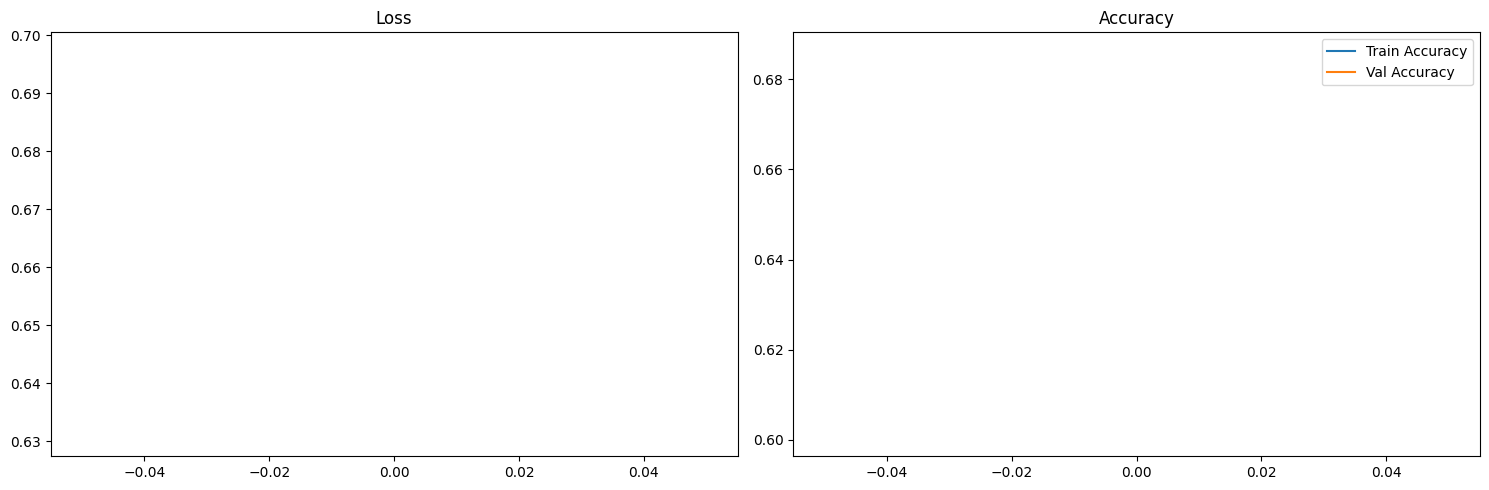

epoch 2:   0%|          | 0/1682 [00:00<?, ?it/s]

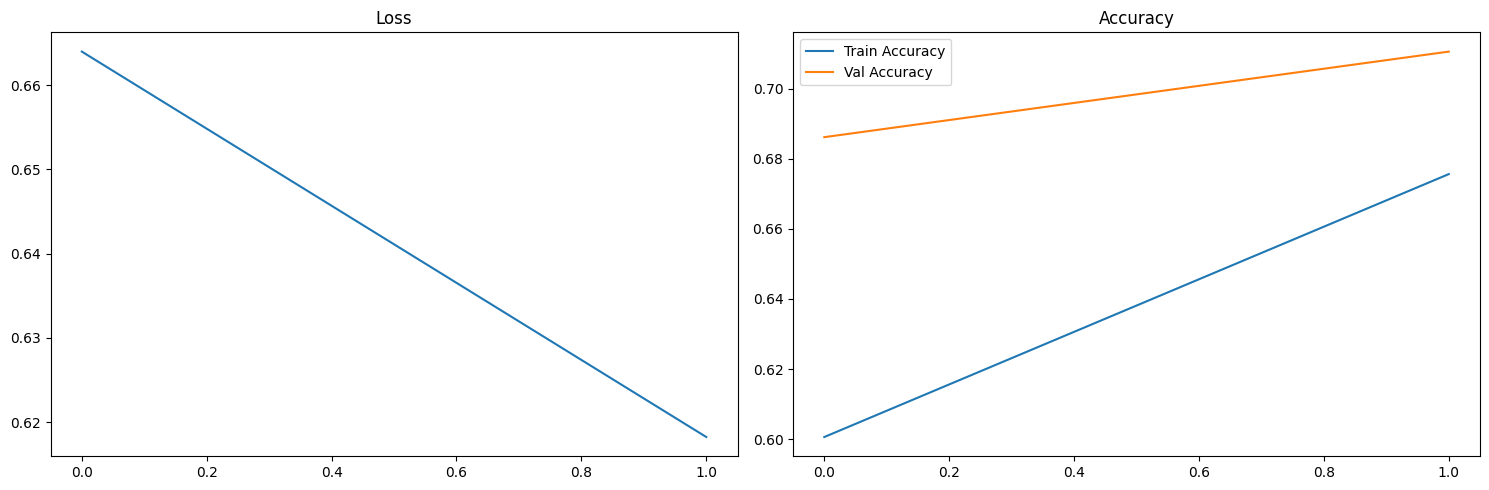

epoch 3:   0%|          | 0/1682 [00:00<?, ?it/s]

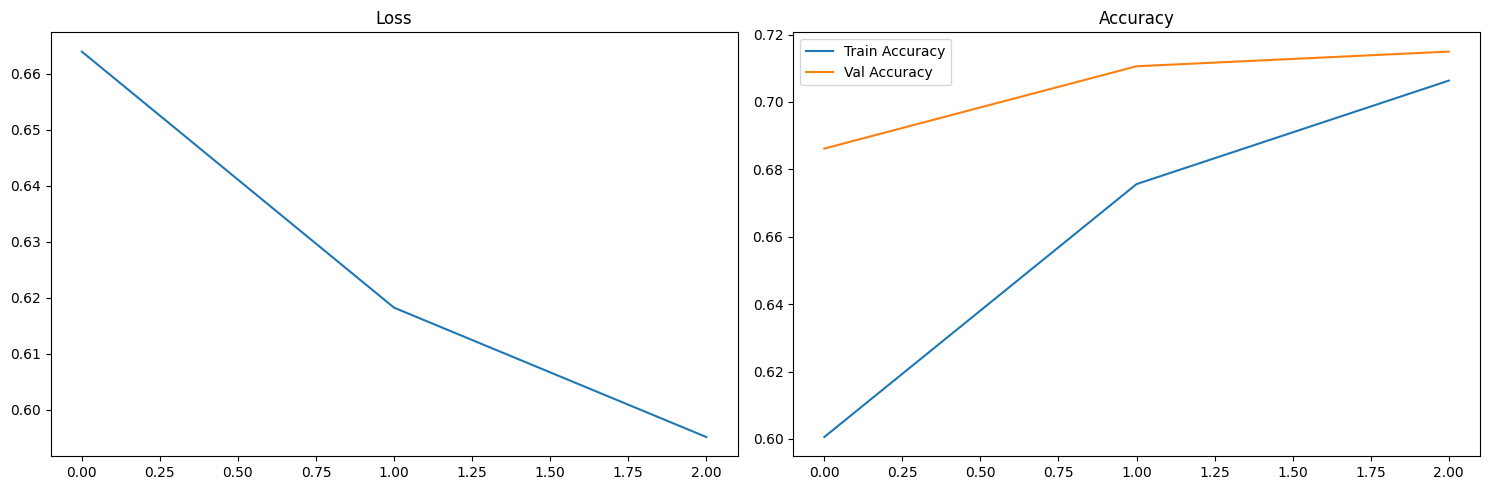

epoch 4:   0%|          | 0/1682 [00:00<?, ?it/s]

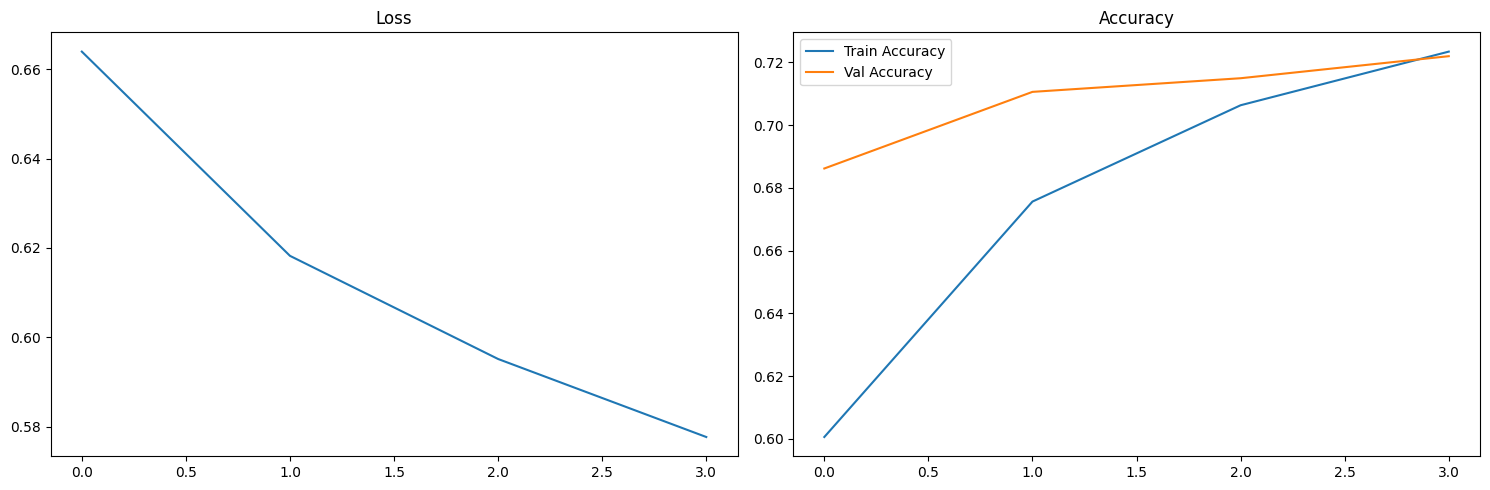

epoch 5:   0%|          | 0/1682 [00:00<?, ?it/s]

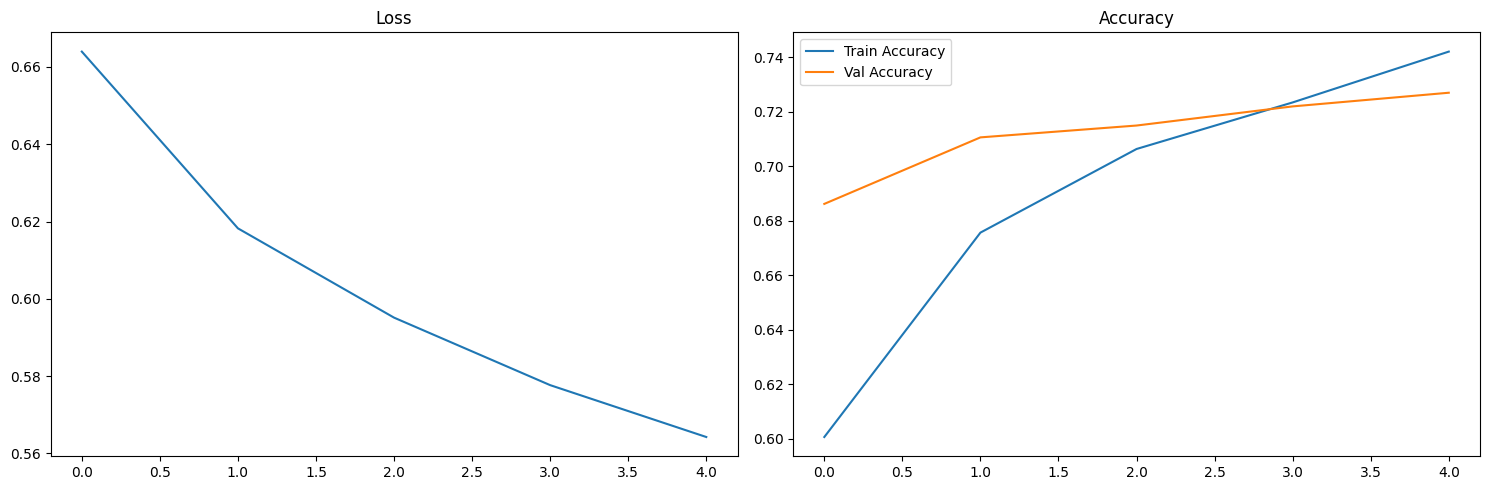

epoch 6:   0%|          | 0/1682 [00:00<?, ?it/s]

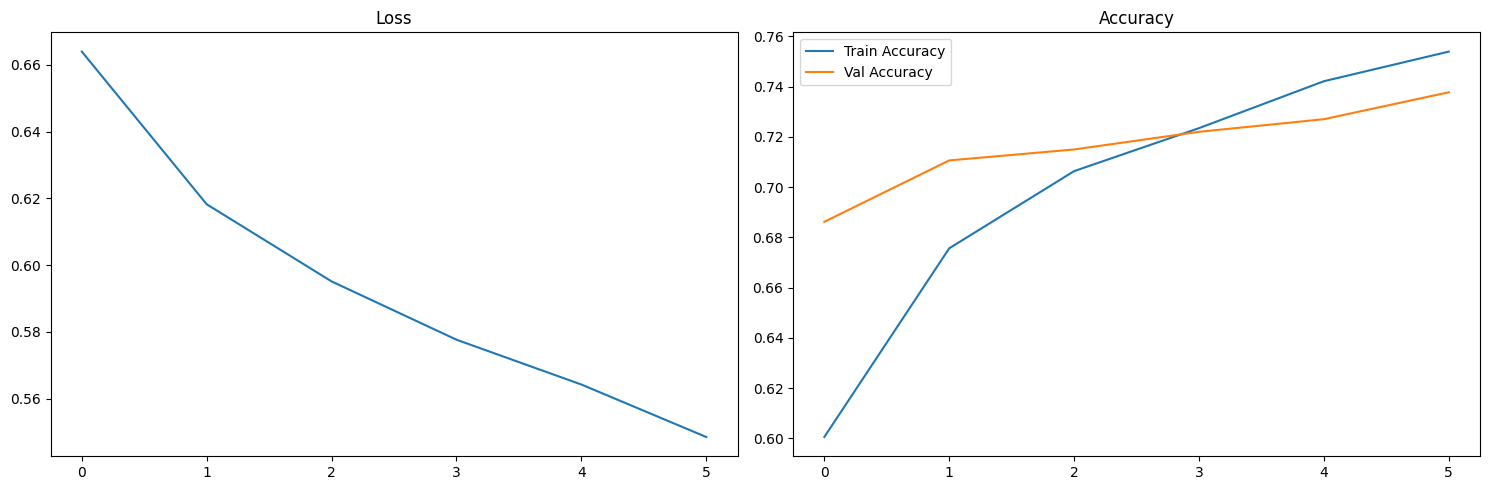

epoch 7:   0%|          | 0/1682 [00:00<?, ?it/s]

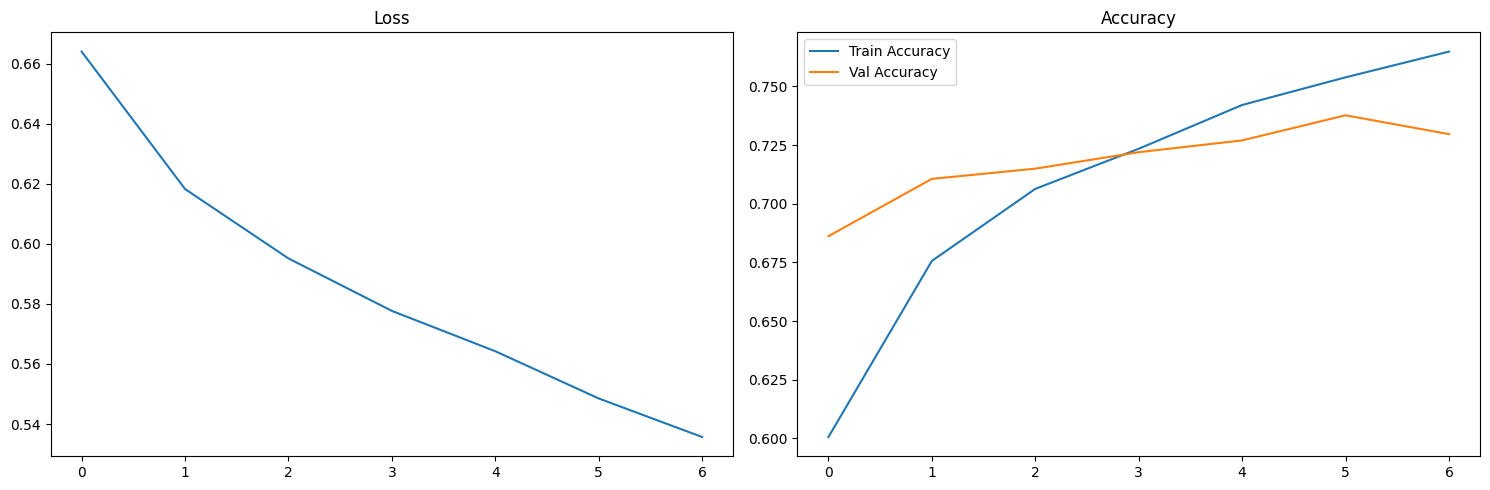

epoch 8:   0%|          | 0/1682 [00:00<?, ?it/s]

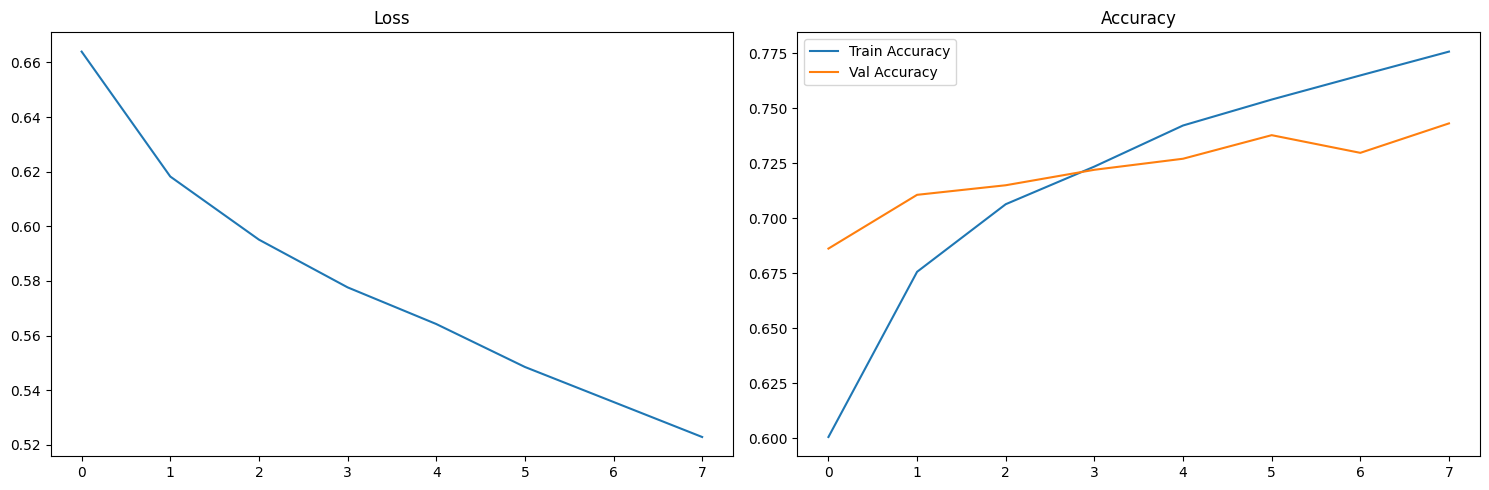

epoch 9:   0%|          | 0/1682 [00:00<?, ?it/s]

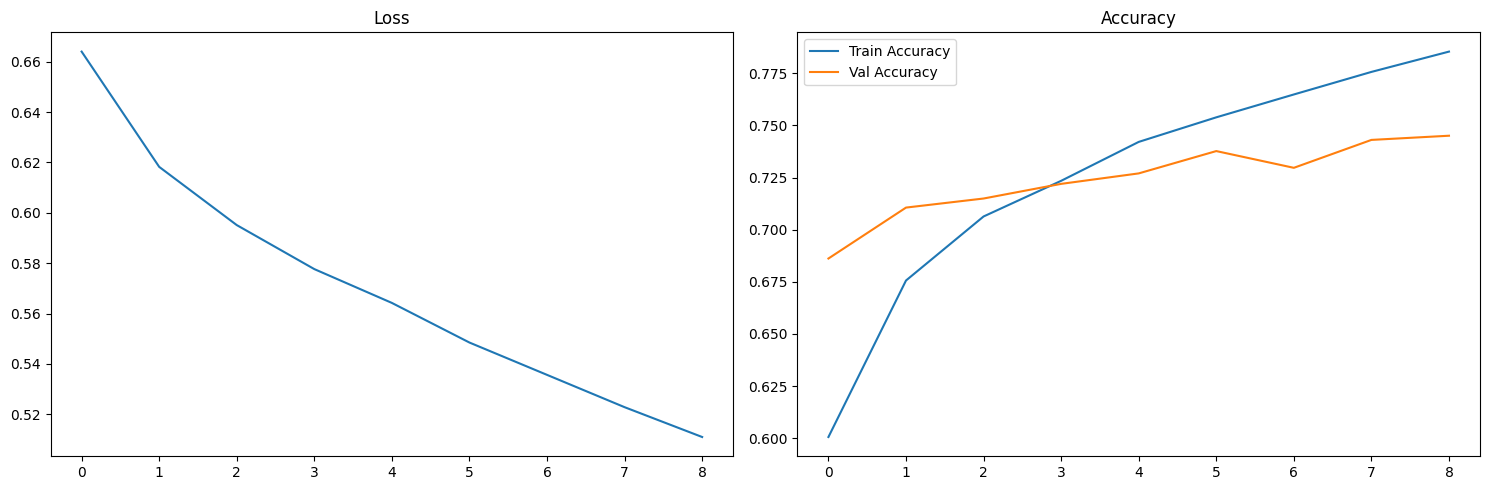

epoch 10:   0%|          | 0/1682 [00:00<?, ?it/s]

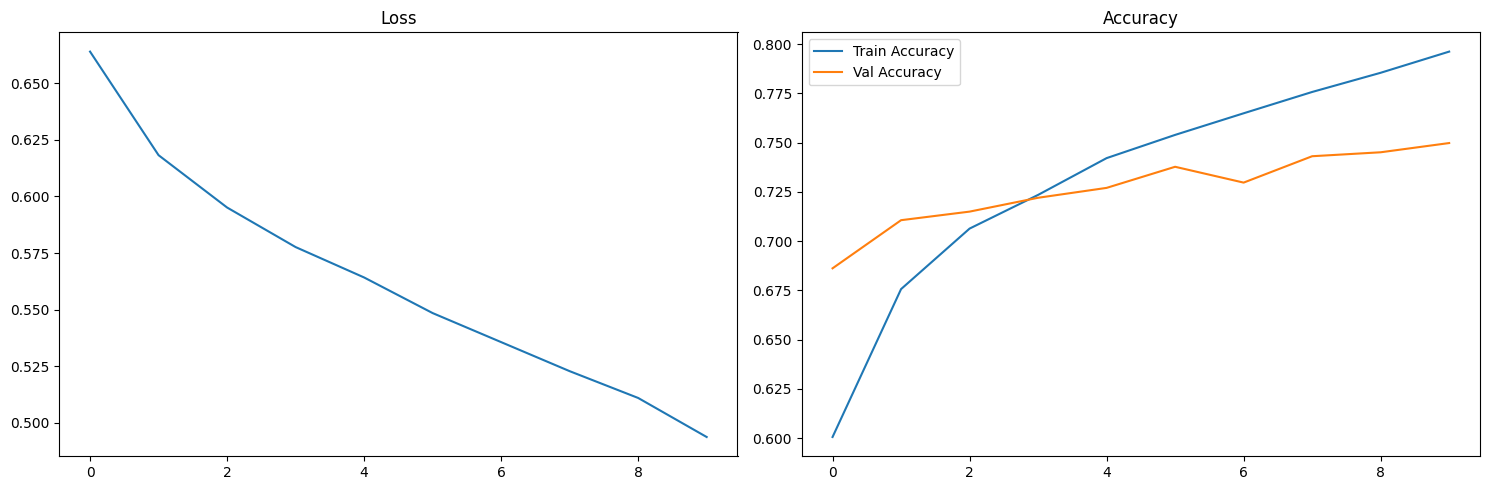

epoch 11:   0%|          | 0/1682 [00:00<?, ?it/s]

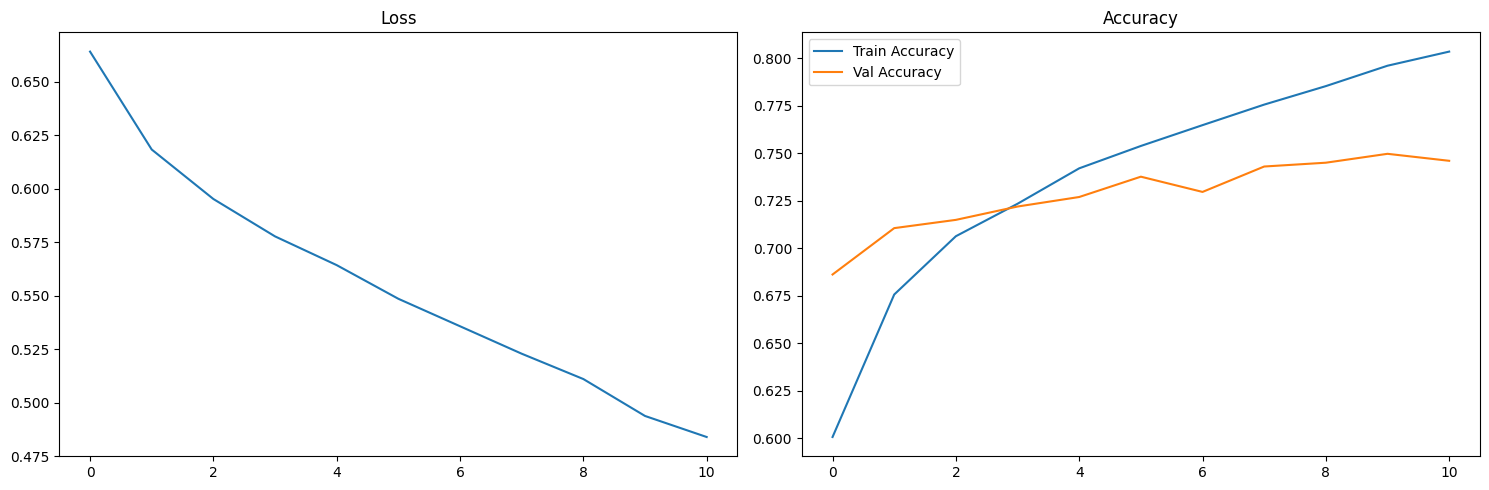

epoch 12:   0%|          | 0/1682 [00:00<?, ?it/s]

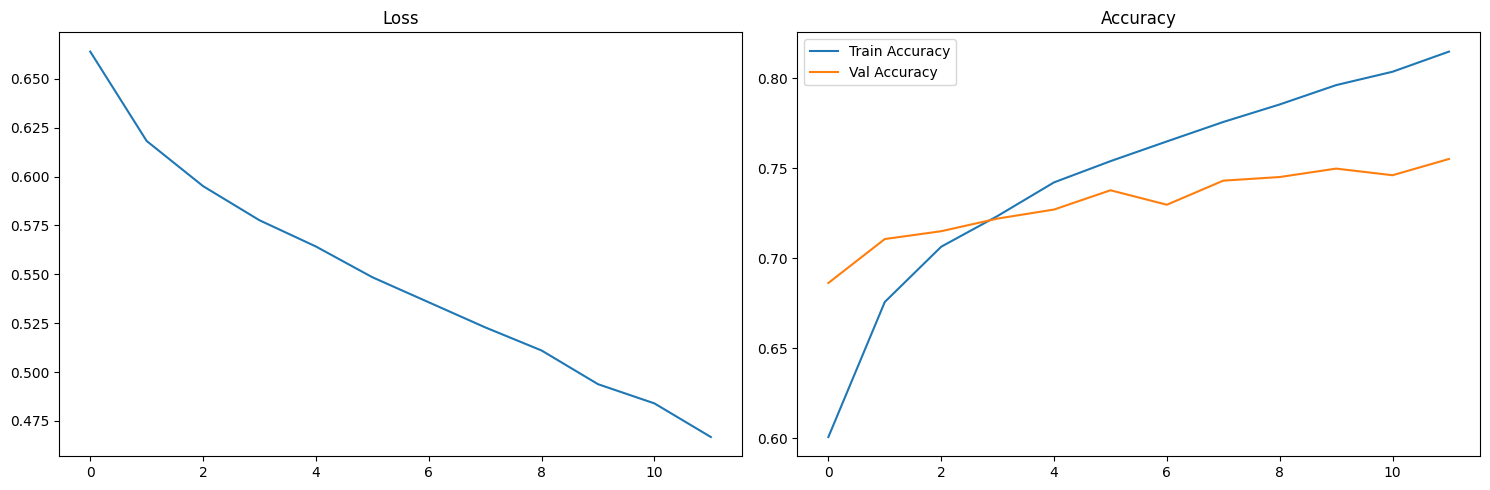

epoch 13:   0%|          | 0/1682 [00:00<?, ?it/s]

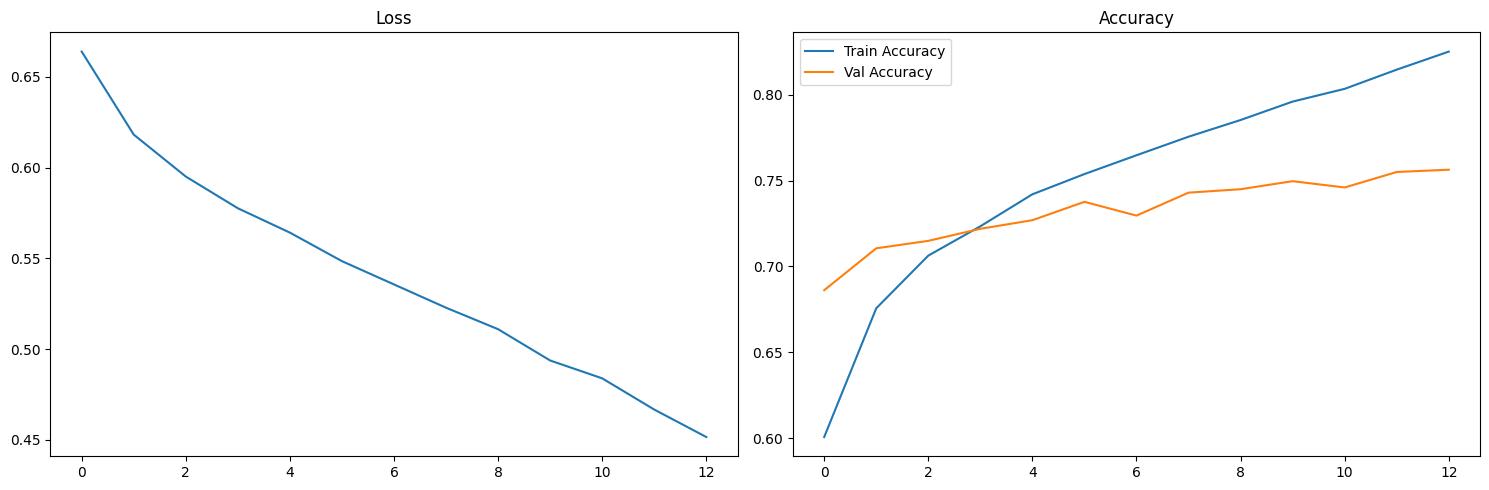

epoch 14:   0%|          | 0/1682 [00:00<?, ?it/s]

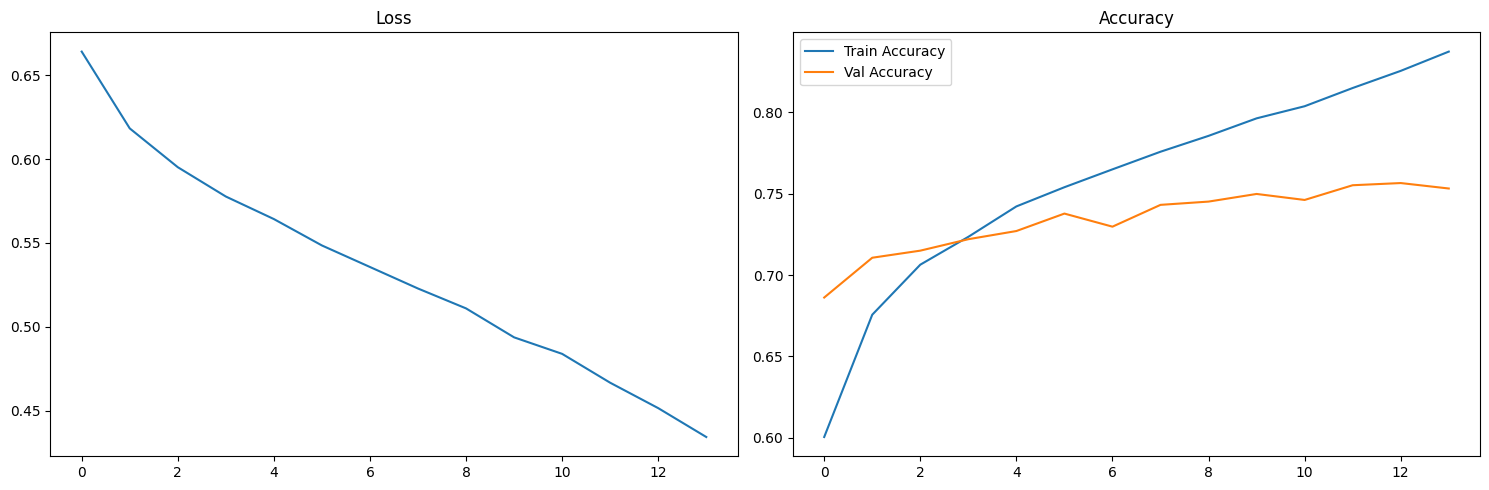

epoch 15:   0%|          | 0/1682 [00:00<?, ?it/s]

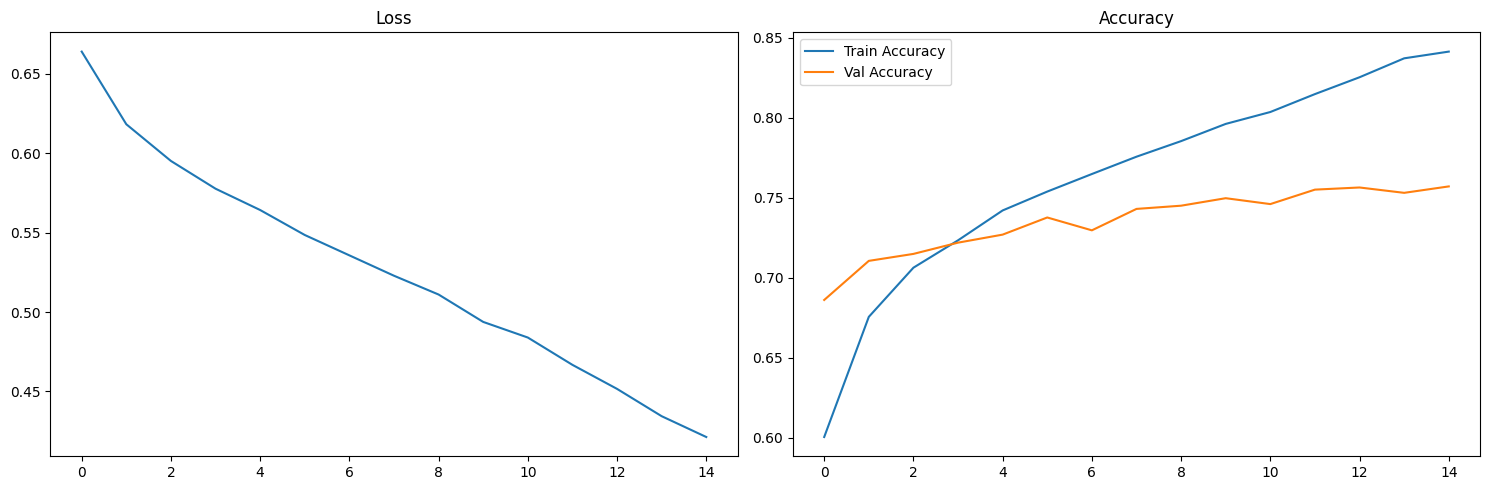

epoch 16:   0%|          | 0/1682 [00:00<?, ?it/s]

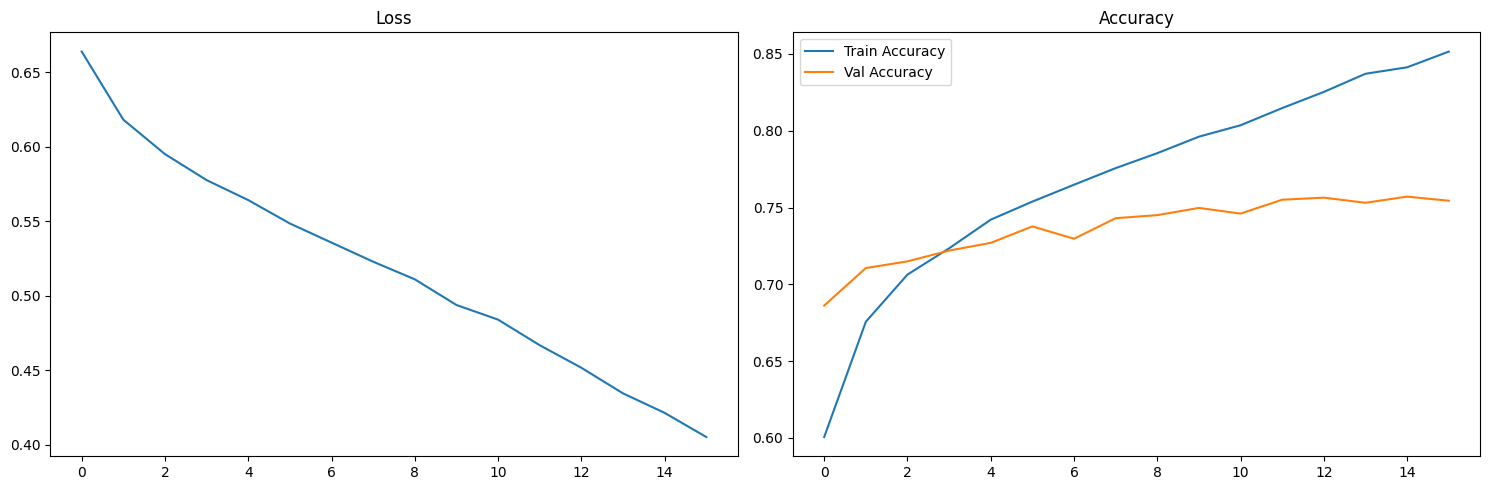

epoch 17:   0%|          | 0/1682 [00:00<?, ?it/s]

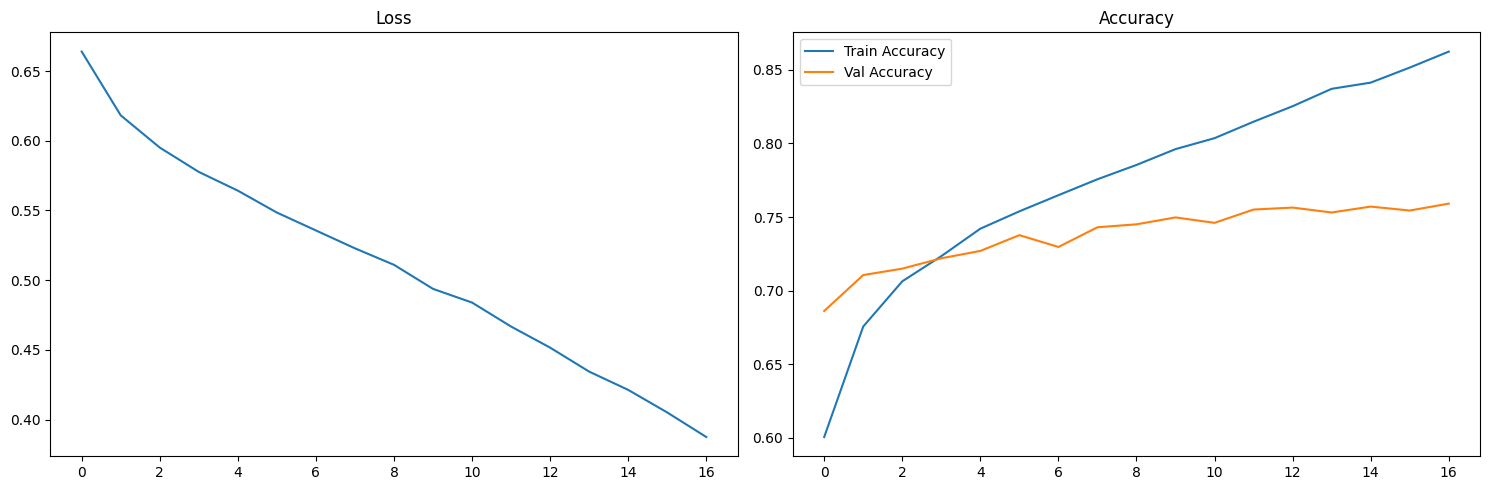

epoch 18:   0%|          | 0/1682 [00:00<?, ?it/s]

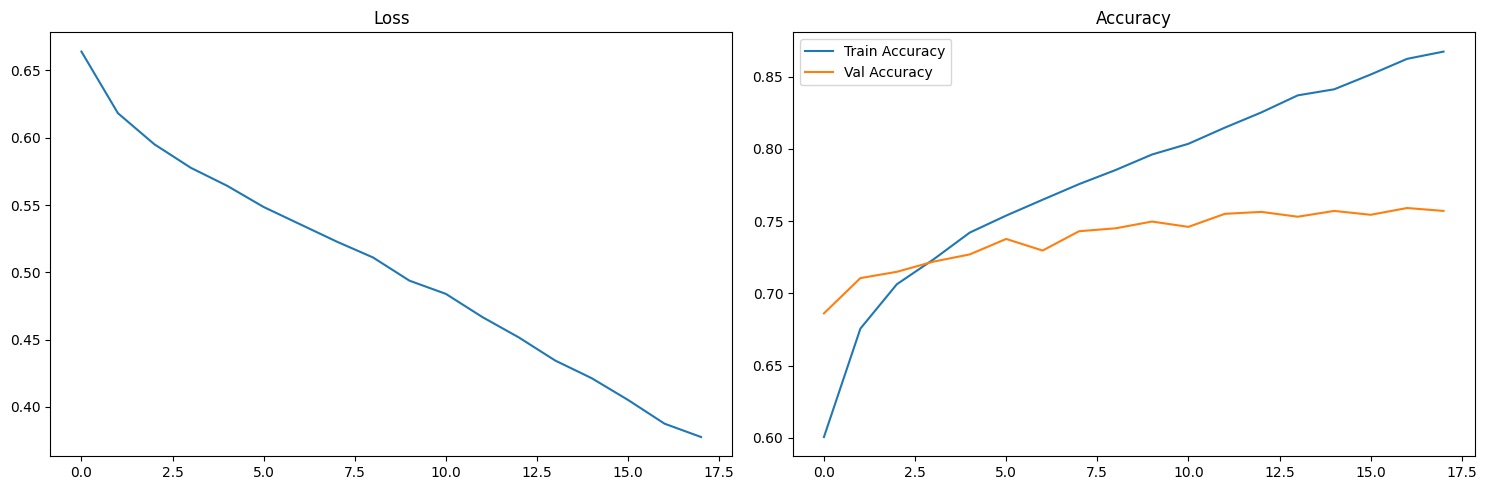

epoch 19:   0%|          | 0/1682 [00:00<?, ?it/s]

In [ ]:
train(baseline, train_loader, val_loader)

In [4]:
baseline = Baseline("sergeyzh/rubert-mini-frida", 312)
baseline.load_state_dict(torch.load('/kaggle/input/dls-project-ds/baseline_maps.pth'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
baseline = baseline.to(device)
baseline.eval()

Baseline(
  (request_emb): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-6): 7 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, elementwis

In [11]:
from tqdm.auto import tqdm
import numpy as np
def check(model, ds):
  correct = 0
  total = len(ds)
  for i in tqdm(range(len(ds))):
    with torch.no_grad():
      logit = model(ds.iloc[i,0], ds.iloc[i,1], ds.iloc[i,2], ds.iloc[i,3], ds.iloc[i,4], ds.iloc[i,5], ds.iloc[i,6])
      pred = (logit > 0.5).float()
      correct += (pred == ds.iloc[i,-1]).float()
  acc = correct / total
  print(acc)

In [12]:
check(baseline,data) # на трейне переобучилась, но это не помешало показать неплохой результат на тесте

  0%|          | 0/29891 [00:00<?, ?it/s]

tensor([[0.9038]], device='cuda:0')


In [13]:
eval_data = pd.read_csv("/kaggle/input/dls-project-ds/eval_maps_big.csv") # предобработка такая же, как у трейна

In [15]:
check(baseline,eval_data)

  0%|          | 0/500 [00:00<?, ?it/s]

tensor([[0.7580]], device='cuda:0')


In [13]:
import pandas as pd
light_data = pd.read_csv('/kaggle/input/train_maps.csv')
light_data # датасет для второго варианта
# 2 фичи: запрос и склейка через теги всей информации об организации
# больше отличий нет (проверка гипотезы о быстром переобучении, которого можно избежать уменьшением модели)

,Text,full,relevance
0,налоговая 5007,"[Address]\n Московская область, Королёв, улиц...",0.0
1,шугаринг Красноярск,"[Address]\n Красноярск, микрорайон Взлётка, у...",1.0
2,новогодняя ночь 2018 в ресторане,"[Address]\n Москва, Кутузовский проспект, 36А...",1.0
3,балетная школа в санкт петербурге 12лет с прож...,"[Address]\n Санкт-Петербург, Невский проспект...",0.0
4,солкосерил гель цена,"[Address]\n Москва, Симферопольский бульвар, ...",1.0
...,...,...,...
29886,нотариус запись,"[Address]\n Москва, 15-я Парковая улица, 45\n...",1.0
29887,стационар для кота москва,"[Address]\n Москва, улица Госпитальный Вал, 3...",0.0
29888,агзс пропан,"[Address]\n Самара, улица 22-го Партсъезда, 4...",0.0
29889,где вибрить ваз 2112,"[Address]\n Нижний Новгород, Московское шоссе...",0.0


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd

class MapsDataset(Dataset):
    def __init__(self, request, response, target):
        self.request = request
        self.response = response
        self.target = torch.tensor(target, dtype=torch.float32)
    def __len__(self):
        return len(self.response)
    def __getitem__(self, idx):
        return {
            'request': self.request[idx],
            'response': self.response[idx],
            'target': self.target[idx]
        }
train_set = light_data.sample(frac=0.9)
val_set = light_data.drop(train_set.index)
train_ds = MapsDataset(
    request=train_set['Text'].tolist(),
    response=train_set['full'].tolist(),
    target=train_set['relevance'].tolist()
)
val_ds = MapsDataset(
    request=val_set['Text'].tolist(),
    response=val_set['full'].tolist(),
    target=val_set['relevance'].tolist()
)

def custom_collate(batch):
    return {
        'request': [item['request'] for item in batch],
        'response': [item['response'] for item in batch],
        'target': torch.tensor([item['target'] for item in batch], dtype=torch.float)
    }

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, collate_fn=custom_collate)
val_loader = DataLoader(val_ds, batch_size=16, collate_fn=custom_collate)

In [3]:
import torch
from torch import nn
from transformers import AutoTokenizer, AutoModel

class LightBaseline(nn.Module):
    def __init__(self, base_transformer_model, out_len):
        super().__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(base_transformer_model, output_hidden_states=True)
        self.request_emb = AutoModel.from_pretrained(base_transformer_model, output_hidden_states=True)
        self.response_emb = AutoModel.from_pretrained(base_transformer_model, output_hidden_states=True)
        
        self.linear1_rq = nn.Linear(out_len,128)
        self.linear1_rs = nn.Linear(out_len,128)
        self.layer_norm_1_rq = nn.LayerNorm(128)
        self.layer_norm_1_rs = nn.LayerNorm(128)
        
        self.linear2_rq = nn.Linear(128,32)
        self.linear2_rs = nn.Linear(128,32)
        self.layer_norm_2_rq = nn.LayerNorm(32)
        self.layer_norm_2_rs = nn.LayerNorm(32)

        self.linear3_rq = nn.Linear(32,8)
        self.linear3_rs = nn.Linear(32,8)
        self.layer_norm_3_rq = nn.LayerNorm(8)
        self.layer_norm_3_rs = nn.LayerNorm(8)

        self.linear4 = nn.Linear(16,8)
        self.layer_norm_4 = nn.LayerNorm(8)

        self.linear5 = nn.Linear(8,1)
        
        self.non_lin1 = nn.Tanh()
        self.non_lin2 = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, inputs_rq, inputs_rs):
        input_rq = self.tokenizer(inputs_rq, padding=True, truncation=True, return_tensors="pt").to(self.request_emb.device)
        input_rs = self.tokenizer(inputs_rs, padding=True, truncation=True, return_tensors="pt").to(self.response_emb.device)
        
        outputs_rq = self.request_emb(**input_rq,output_hidden_states=True)
        last_hidden_rq = outputs_rq.hidden_states[-1][:, 0, :]
        outputs_rs = self.response_emb(**input_rs,output_hidden_states=True)
        last_hidden_rs = outputs_rs.hidden_states[-1][:, 0, :]

        def process_stream(x, linear1, linear2, linear3, ln1, ln2, ln3):
            x = self.non_lin1(ln1(linear1(x)))
            x = self.dropout(x)
            x = self.non_lin1(ln2(linear2(x)))
            x = self.dropout(x)
            x = self.non_lin1(ln3(linear3(x)))
            return self.dropout(x)

        rq_stream = process_stream(last_hidden_rq, 
                                self.linear1_rq, 
                                self.linear2_rq, 
                                self.linear3_rq,
                                self.layer_norm_1_rq,
                                self.layer_norm_2_rq,
                                self.layer_norm_3_rq)

        rs_stream = process_stream(last_hidden_rs,
                                self.linear1_rs,
                                self.linear2_rs,
                                self.linear3_rs,
                                self.layer_norm_1_rs,
                                self.layer_norm_2_rs,
                                self.layer_norm_3_rs)

        combined = torch.cat([
            rq_stream, 
            rs_stream,
        ], dim=1)
        x = self.layer_norm_4(self.linear4(combined))
        x = self.non_lin1(x)
        x = self.dropout(x)
        x = self.linear5(x)
        return self.non_lin2(x)

In [4]:
from tqdm.auto import tqdm
import copy
import matplotlib.pyplot as plt
import numpy as np
def train(model_base, train_loader, val_loader, num_epochs=100, learning_rate=1e-5):
    best = 0.0
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = copy.deepcopy(model_base)
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(),lr=learning_rate)
    criterion = nn.BCELoss()
    train_losses, train_accs, val_accs = [], [], []
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct_train = 0
        total_train = 0
        for batch in tqdm(train_loader, desc=f'epoch {epoch+1}'):
            optimizer.zero_grad()
            request = batch['request']
            response = batch['response']
            target = batch['target'].to(device).unsqueeze(1)
        
            logits = model(request, response)
            loss = criterion(logits, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            preds = (logits > 0.5).float()
            correct_train += (preds == target).sum().item()
            total_train += target.size(0)

        train_acc = correct_train / total_train
        train_losses.append(total_loss / len(train_loader))
        train_accs.append(train_acc)
        
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for batch in val_loader:
                request = batch['request']
                response = batch['response']
                target = batch['target'].to(device).unsqueeze(1)
                logits = model(request, response)
                preds = (logits > 0.5).float()
                correct_val += (preds == target).sum().item()
                total_val += target.size(0)
        val_acc = correct_val / total_val
        val_accs.append(val_acc)
        if val_accs[-1]>best:
            best = val_accs[-1]
            torch.save(model.state_dict(), 'light_baseline_maps.pth')
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.title('Loss')
        plt.subplot(1, 2, 2)
        plt.plot(train_accs, label='Train Accuracy')
        plt.plot(val_accs, label='Val Accuracy')
        plt.title('Accuracy')
        plt.legend()
        plt.tight_layout()
        plt.show()

In [5]:
baseline = LightBaseline("sergeyzh/rubert-mini-frida", 312)

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.41M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/732 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/712 [00:00<?, ?B/s]

2025-06-17 15:26:23.462134: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750173983.662045      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750173983.720299      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/129M [00:00<?, ?B/s]

In [6]:
torch.cuda.empty_cache()

epoch 1:   0%|          | 0/1682 [00:00<?, ?it/s]

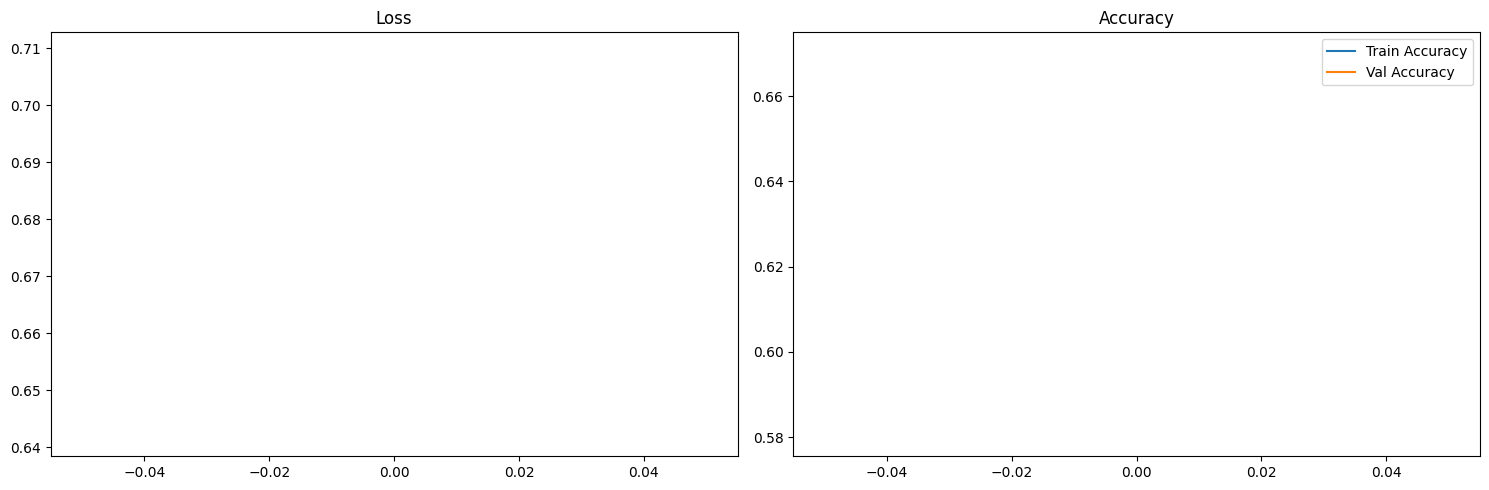

epoch 2:   0%|          | 0/1682 [00:00<?, ?it/s]

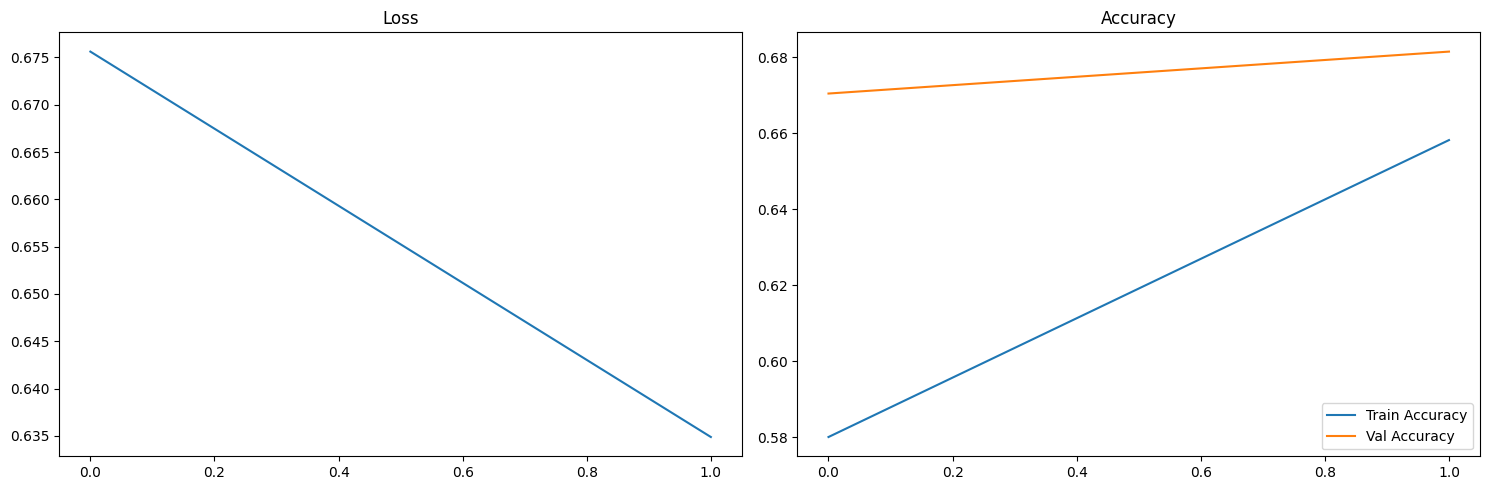

epoch 3:   0%|          | 0/1682 [00:00<?, ?it/s]

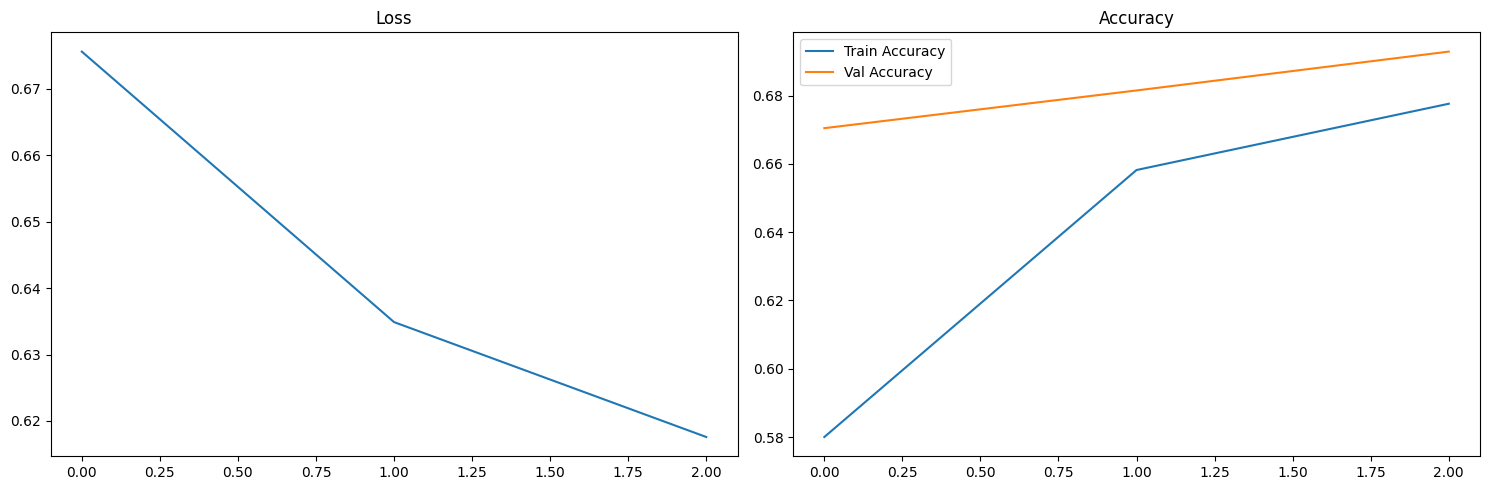

epoch 4:   0%|          | 0/1682 [00:00<?, ?it/s]

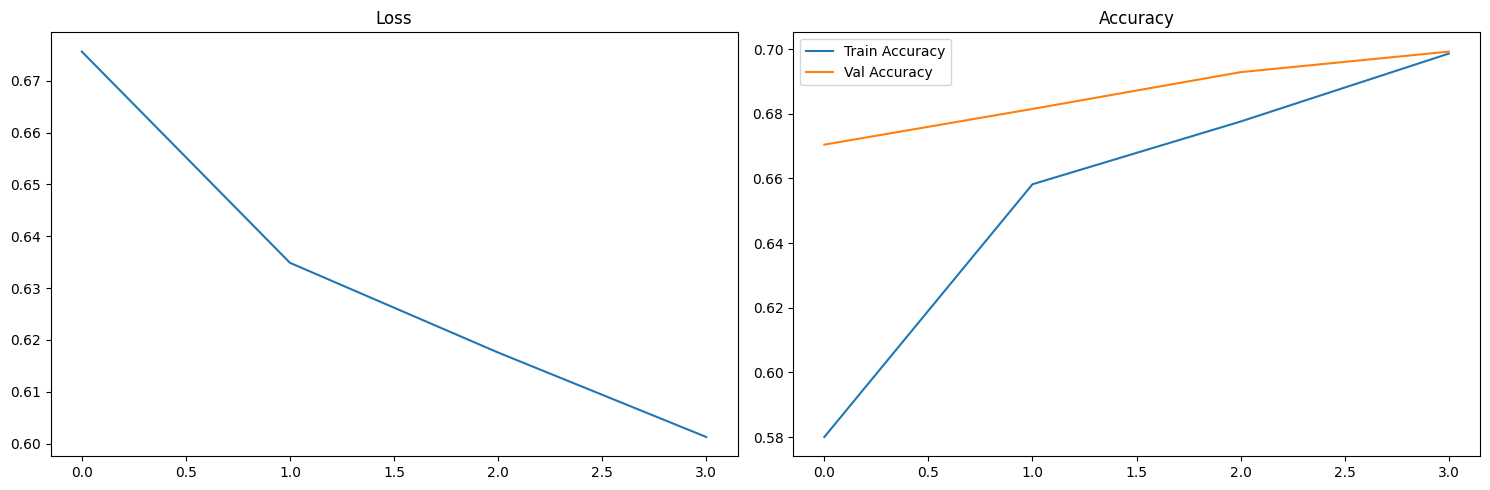

epoch 5:   0%|          | 0/1682 [00:00<?, ?it/s]

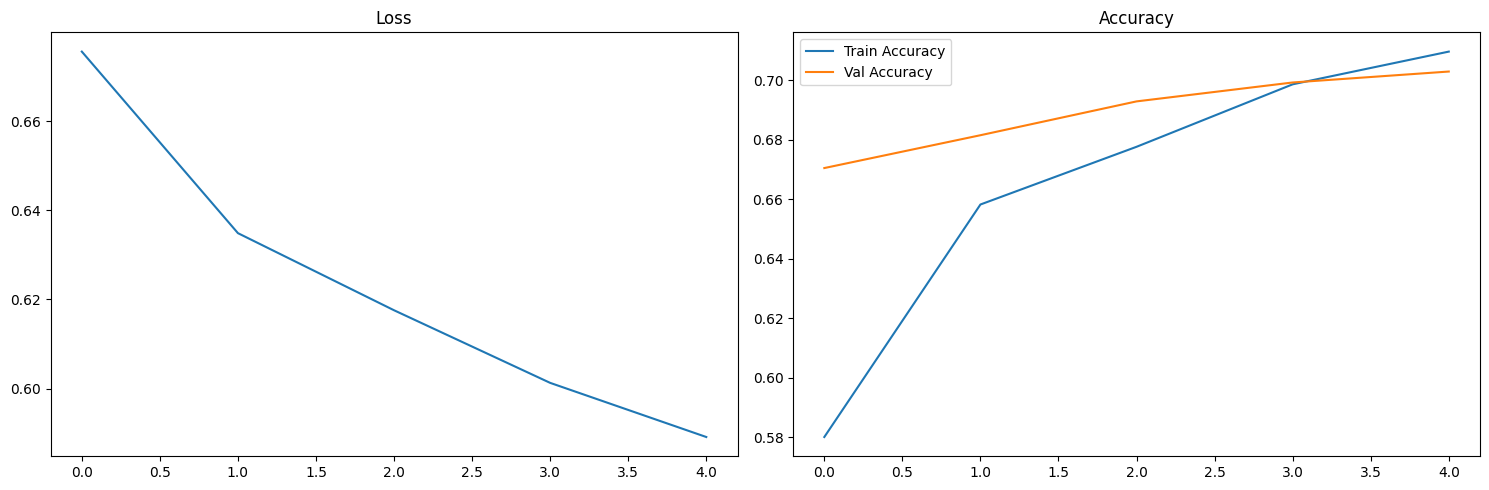

epoch 6:   0%|          | 0/1682 [00:00<?, ?it/s]

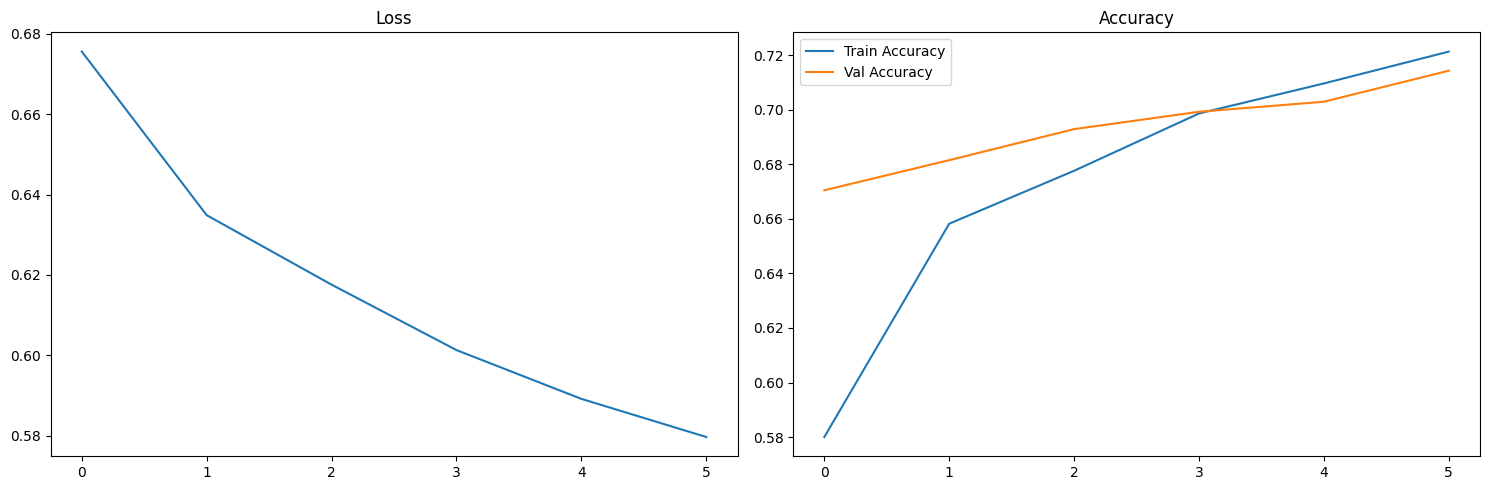

epoch 7:   0%|          | 0/1682 [00:00<?, ?it/s]

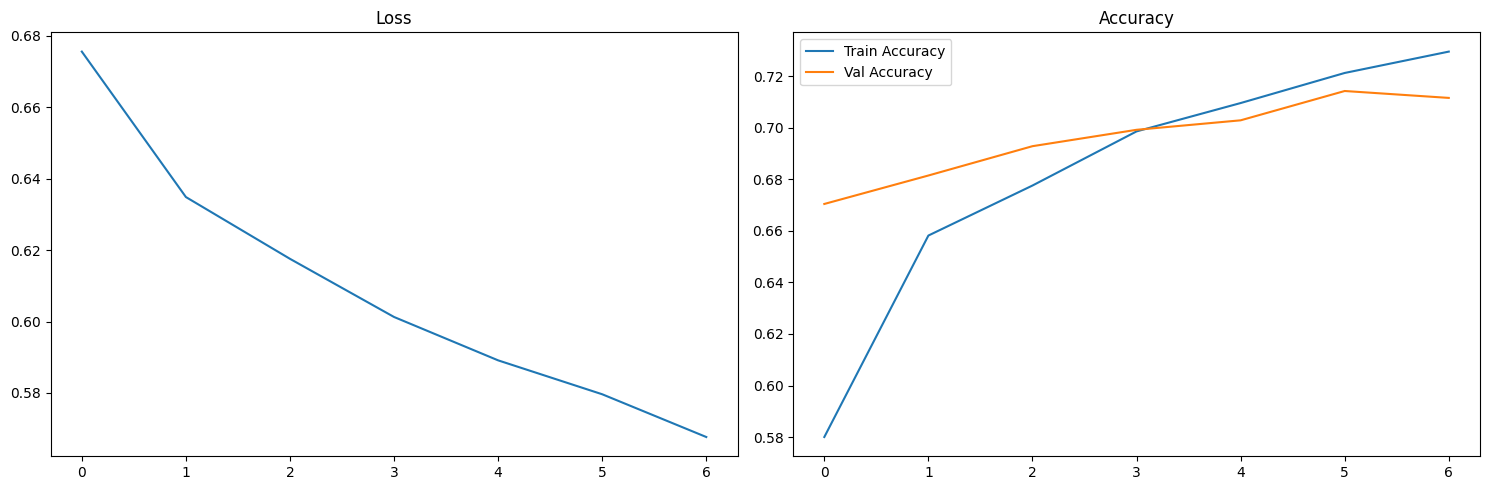

epoch 8:   0%|          | 0/1682 [00:00<?, ?it/s]

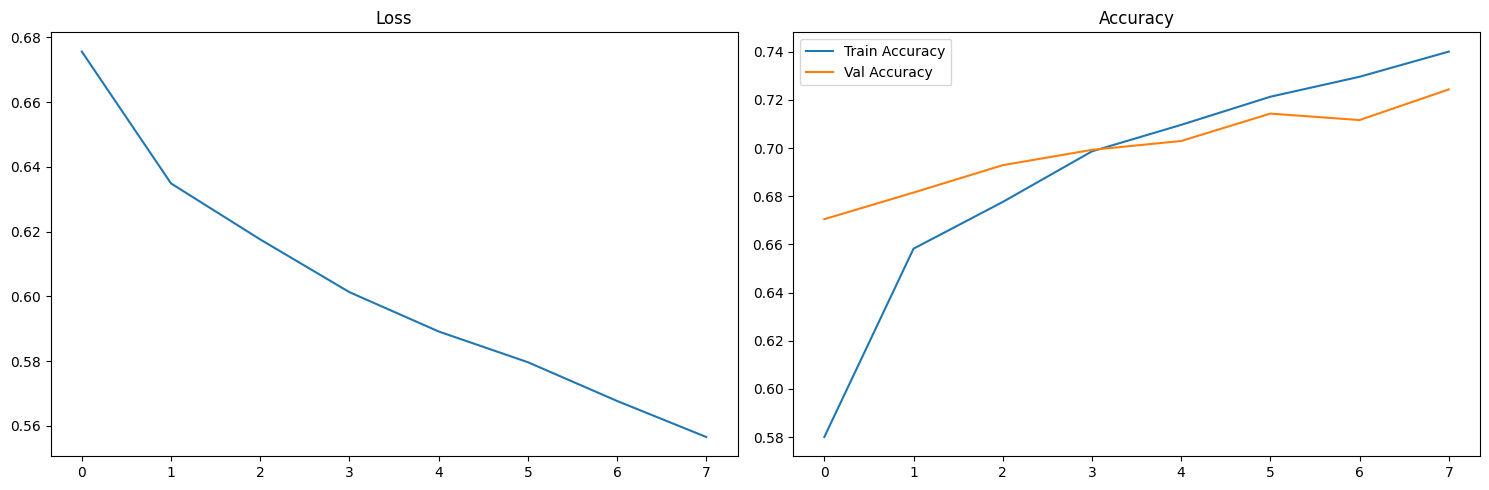

epoch 9:   0%|          | 0/1682 [00:00<?, ?it/s]

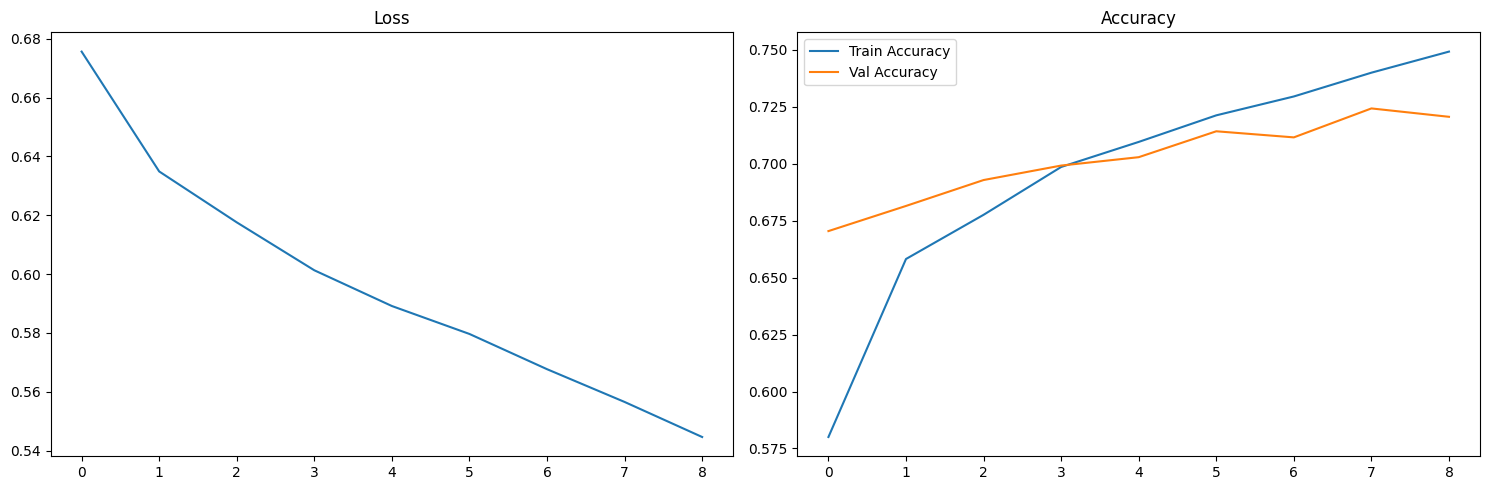

epoch 10:   0%|          | 0/1682 [00:00<?, ?it/s]

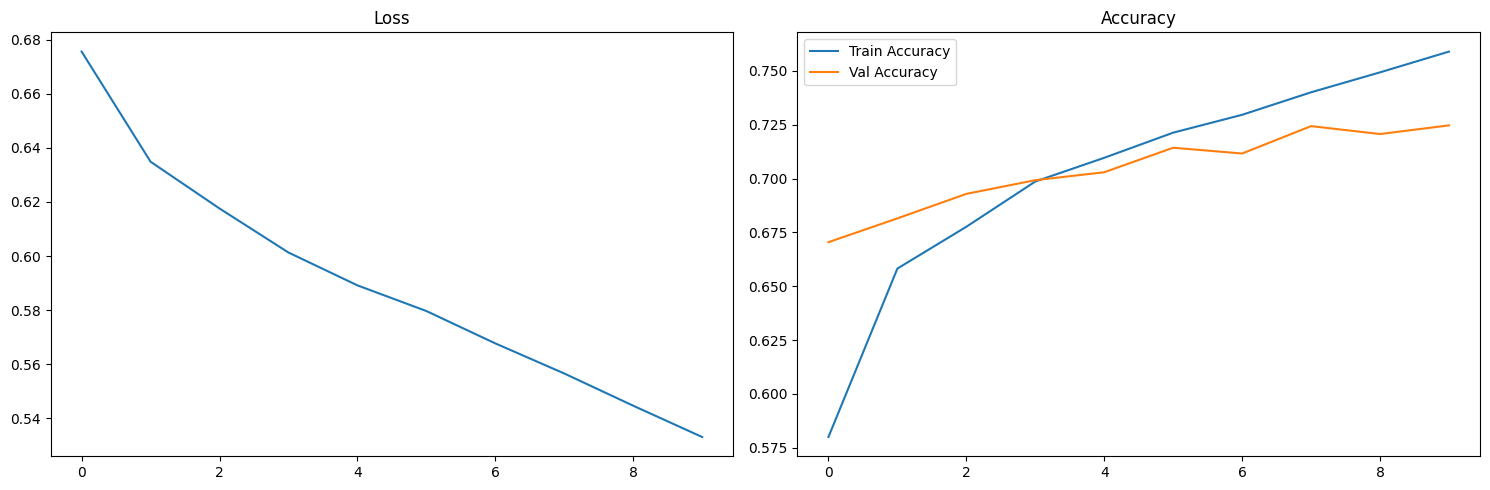

epoch 11:   0%|          | 0/1682 [00:00<?, ?it/s]

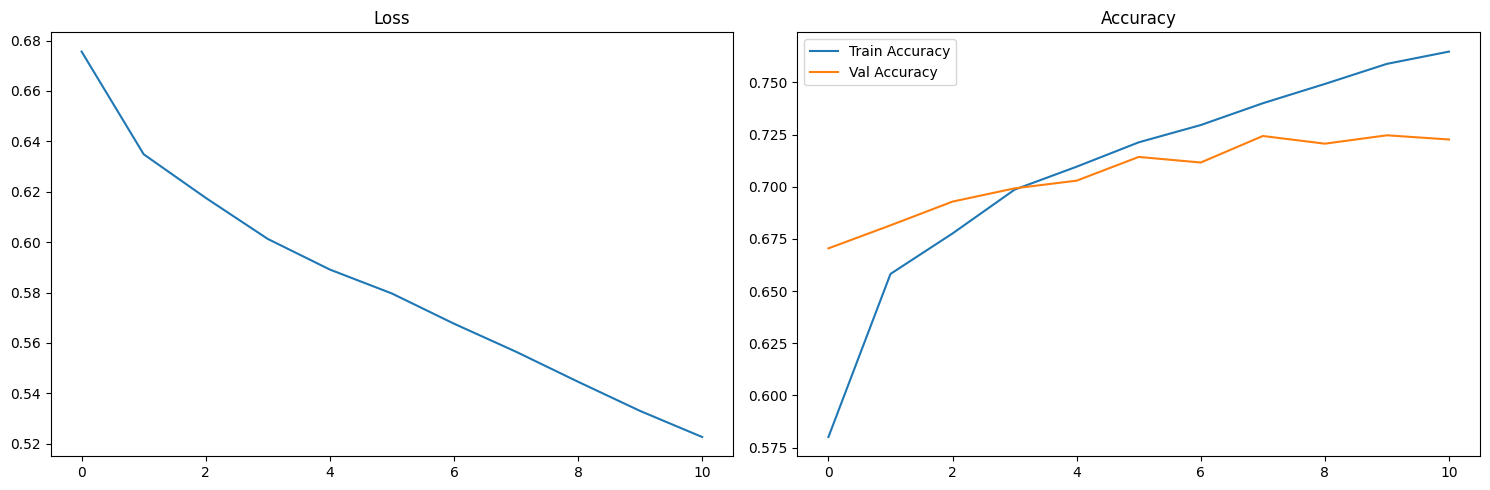

epoch 12:   0%|          | 0/1682 [00:00<?, ?it/s]

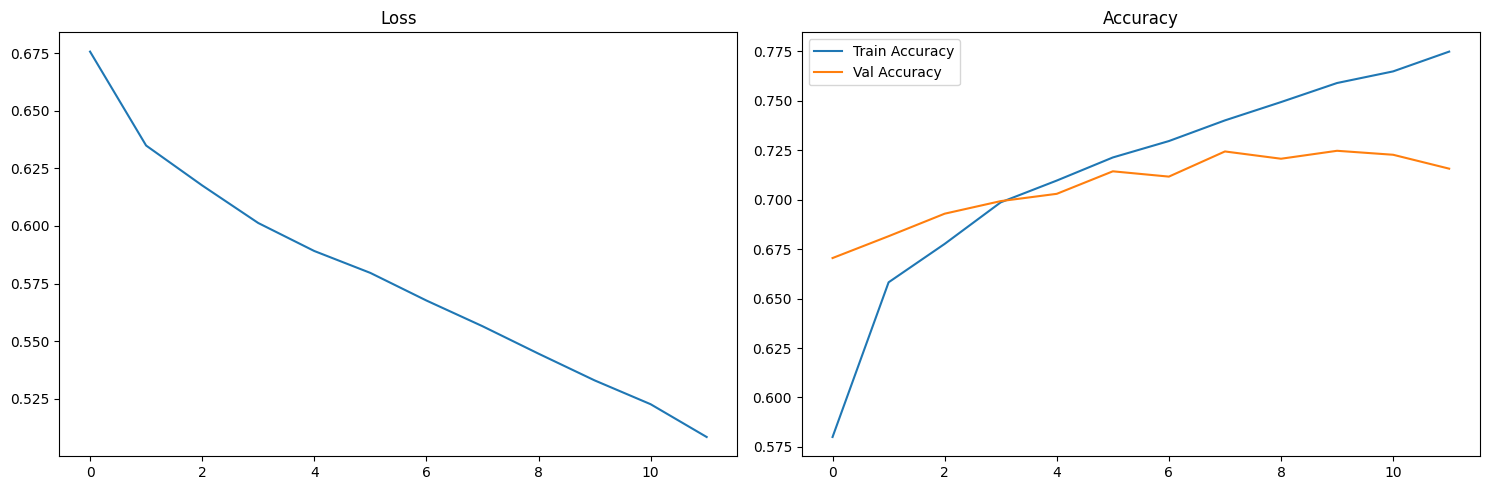

epoch 13:   0%|          | 0/1682 [00:00<?, ?it/s]

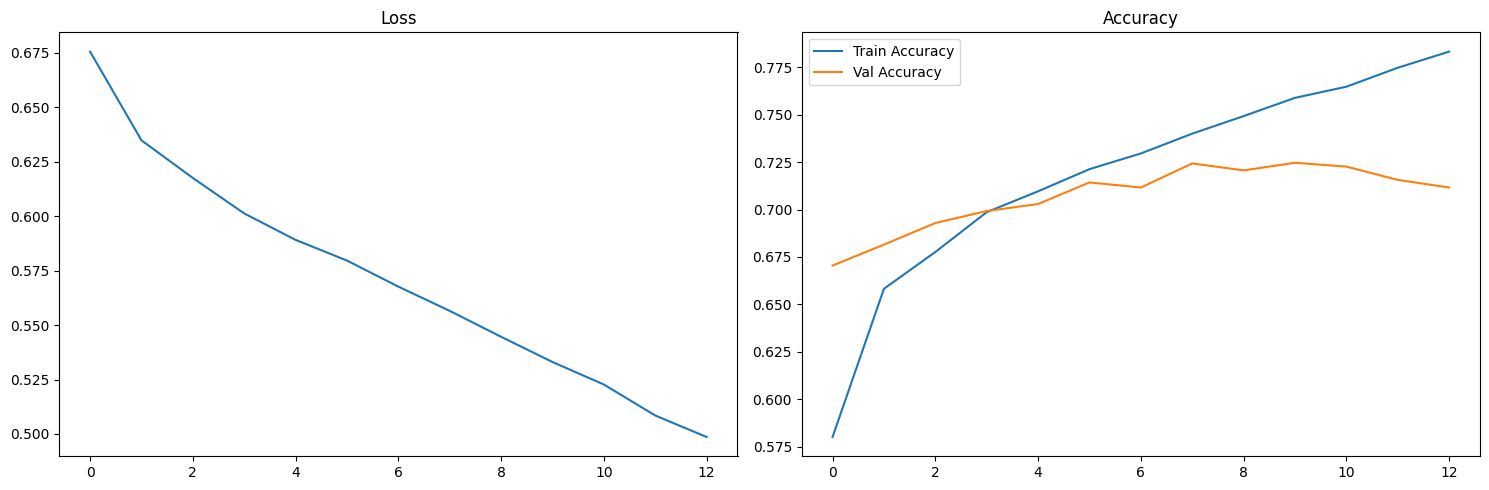

epoch 14:   0%|          | 0/1682 [00:00<?, ?it/s]

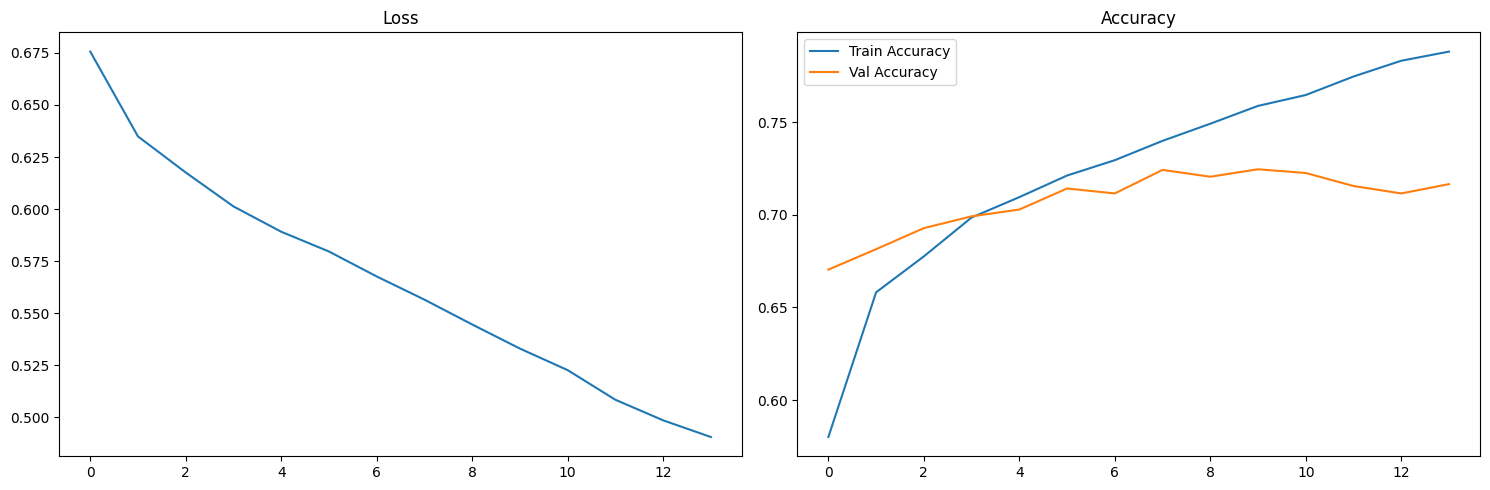

epoch 15:   0%|          | 0/1682 [00:00<?, ?it/s]

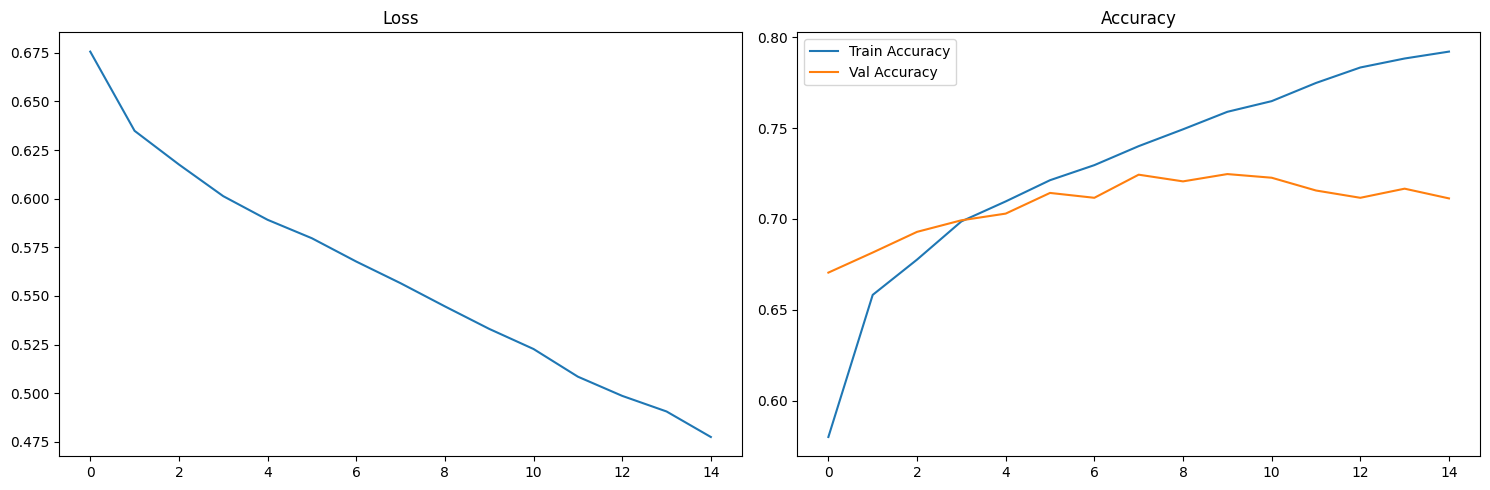

epoch 16:   0%|          | 0/1682 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [7]:
train(baseline, train_loader, val_loader)

In [8]:
baseline = LightBaseline("sergeyzh/rubert-mini-frida", 312)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
baseline = baseline.to(device)

In [9]:
baseline.load_state_dict(torch.load('/kaggle/working/light_baseline_maps.pth'))
baseline.eval()

LightBaseline(
  (request_emb): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-6): 7 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, eleme

In [14]:
from tqdm.auto import tqdm
import numpy as np
def check(model, ds):
  correct = 0
  total = len(ds)
  for i in tqdm(range(len(ds))):
    with torch.no_grad():
      logit = model(ds.iloc[i,0], ds.iloc[i,1])
      pred = (logit > 0.5).float()
      correct += (pred == ds.iloc[i,-1]).float()
  acc = correct / total
  print(acc)

In [14]:
import pandas as pd
data_eval = pd.read_csv('/kaggle/input/eval_maps.csv')
data_eval

,Text,full,relevance
0,сигары,"[Address]\n Москва, Дубравная улица, 34/29\n ...",1.0
1,кальянная спб мероприятия,"[Address]\n Санкт-Петербург, Большой проспект...",0.0
2,Эпиляция,"[Address]\n Московская область, Одинцово, ули...",1.0
3,стиральных машин,"[Address]\n Москва, улица Обручева, 34/63\n ...",1.0
4,сеть быстрого питания,"[Address]\n Санкт-Петербург, 1-я Красноармейс...",1.0
...,...,...,...
495,наращивание ресниц,"[Address]\n Саратов, улица имени А.С. Пушкина...",1.0
496,игры,"[Address]\n Москва, Щёлковское шоссе, 79, кор...",0.0
497,домашний интернет в курске что подключить отзы...,"[Address]\n Курск, Садовая улица, 5\n [Name]...",0.0
498,гостиница волгодонск сауна номер телефона,"[Address]\n Ростовская область, городской окр...",0.0


In [16]:
check(baseline, light_data)

  0%|          | 0/29891 [00:00<?, ?it/s]

tensor([[0.7853]], device='cuda:0')


In [15]:
check(baseline, data_eval) # переобучение на трейне незначительно, но модели не хватило степеней свободы, чтобы побить первый вариант

  0%|          | 0/500 [00:00<?, ?it/s]

tensor([[0.7340]], device='cuda:0')


In [16]:
data = pd.read_csv('/kaggle/input/eval_gemini_exp1_exp2.csv')
data # сначала экспериментировал с агентами, потом решил сохранить решение бейзлайна в тот же файл
# далее сохраним предикты бейзлайна, чтобы data выглядела так, как ниже

,request,response,target,gemini_2.5_flash_exp1,gemini_2.0_flash_exp2,baseline
0,сигары,"[Address]\n Москва, Дубравная улица, 34/29\n ...",1.0,1.0,1.0,1.0
1,кальянная спб мероприятия,"[Address]\n Санкт-Петербург, Большой проспект...",0.0,0.0,0.0,0.0
2,Эпиляция,"[Address]\n Московская область, Одинцово, ули...",1.0,1.0,1.0,1.0
3,стиральных машин,"[Address]\n Москва, улица Обручева, 34/63\n ...",1.0,1.0,1.0,1.0
4,сеть быстрого питания,"[Address]\n Санкт-Петербург, 1-я Красноармейс...",1.0,1.0,1.0,1.0
...,...,...,...,...,...,...
495,наращивание ресниц,"[Address]\n Саратов, улица имени А.С. Пушкина...",1.0,1.0,0.0,0.0
496,игры,"[Address]\n Москва, Щёлковское шоссе, 79, кор...",0.0,1.0,1.0,1.0
497,домашний интернет в курске что подключить отзы...,"[Address]\n Курск, Садовая улица, 5\n [Name]...",0.0,0.0,1.0,0.0
498,гостиница волгодонск сауна номер телефона,"[Address]\n Ростовская область, городской окр...",0.0,1.0,1.0,1.0


In [14]:
# останавливаемся на первом варианте и сохраняем его предикты в датасет
# они будут использоваться в качестве тула для агента: если он неуверен, то может посмотреть решение бейзлайна
from tqdm.auto import tqdm
data['baseline']=2.0 
def check(model, ds):
  global data
  correct = 0
  total = len(ds)
  for i in tqdm(range(len(ds))):
    with torch.no_grad():
      logit = model(ds.iloc[i,0], ds.iloc[i,1], ds.iloc[i,2], ds.iloc[i,3], ds.iloc[i,4], ds.iloc[i,5], ds.iloc[i,6])
      pred = (logit > 0.5).float()
      data.iloc[i,-1]=pred[0][0].item()
      correct += (pred == ds.iloc[i,-1]).float()
  acc = correct / total
  print(acc)

In [15]:
check(baseline,data_big)

  0%|          | 0/500 [00:00<?, ?it/s]

tensor([[0.7580]], device='cuda:0')


## Проведем переоценку на обновленных целевых метках

In [2]:
import pandas as pd
data = pd.read_csv('/kaggle/input/eval_gemini_exp1_exp2.csv')
data

,request,response,target,gemini_2.5_flash_exp1,gemini_2.0_flash_exp2,baseline
0,сигары,"[Address]\n Москва, Дубравная улица, 34/29\n ...",1.0,1.0,1.0,1.0
1,кальянная спб мероприятия,"[Address]\n Санкт-Петербург, Большой проспект...",0.0,0.0,0.0,0.0
2,Эпиляция,"[Address]\n Московская область, Одинцово, ули...",1.0,1.0,1.0,1.0
3,стиральных машин,"[Address]\n Москва, улица Обручева, 34/63\n ...",1.0,1.0,1.0,1.0
4,сеть быстрого питания,"[Address]\n Санкт-Петербург, 1-я Красноармейс...",1.0,1.0,1.0,1.0
...,...,...,...,...,...,...
495,наращивание ресниц,"[Address]\n Саратов, улица имени А.С. Пушкина...",1.0,1.0,0.0,0.0
496,игры,"[Address]\n Москва, Щёлковское шоссе, 79, кор...",0.0,1.0,1.0,1.0
497,домашний интернет в курске что подключить отзы...,"[Address]\n Курск, Садовая улица, 5\n [Name]...",0.0,0.0,1.0,0.0
498,гостиница волгодонск сауна номер телефона,"[Address]\n Ростовская область, городской окр...",0.0,1.0,1.0,1.0


In [3]:
ok = 0
for i in range(500):
    if data.iloc[i,5]==data.iloc[i,2]:
        ok+=1
print(ok/500)

0.71


## Можно получить качество бейзлайна лучше, текущий результат можно объяснить переобучением на шумном трейне 

# Задача агента - приблизиться или побить accuracy=0.71